In [ ]:
!pip install -q "chronos-forecasting>=2.0.0" \
               "neuralforecast@git+https://github.com/Nixtla/neuralforecast.git" \
               "pandas[pyarrow]" \
               scikit-learn \
               fastdtw

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.5/70.5 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.3/72.3 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 143.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import pathlib
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from pandas.tseries.frequencies import to_offset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
from chronos import Chronos2Pipeline

from neuralforecast import NeuralForecast
from neuralforecast.models import PatchTST, DLinear, TimeMixer, iTransformer

plt.rcParams["figure.dpi"] = 120

SEQ_LEN = 336            # input / window length for all models

# Simple train/val/test ratios (no leakage into test)
TRAIN_RATIO = 0.7
VAL_RATIO = 0.1  # test gets the remaining 0.2

DATA_DIR = pathlib.Path("./data")
DATA_DIR.mkdir(exist_ok=True, parents=True)

DATASETS = {
    "ETTh1": DATA_DIR / "ETTh1.csv",
    "ETTm1": DATA_DIR / "ETTm1.csv",
    "ETTm2": DATA_DIR / "ETTm2.csv",
    "Weather": DATA_DIR / "weather.csv",
}

TARGET_COL = "OT"
TIME_COL = "date"

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


In [ ]:
BASE_URL = (
    "https://huggingface.co/datasets/"
    "pkr7098/time-series-forecasting-datasets/resolve/main"
)

FILES = {
    "ETTh1": "ETTh1.csv",
    "ETTm1": "ETTm1.csv",
    "ETTm2": "ETTm2.csv",
    "Weather": "weather.csv",
}

def download_file(name: str, filename: str, overwrite: bool = False):
    url = f"{BASE_URL}/{filename}"
    dest_path = DATA_DIR / filename

    if dest_path.exists() and not overwrite:
        print(f"[skip] {name}: {dest_path} already exists")
        return

    print(f"[download] {name} from {url}")
    resp = requests.get(url, stream=True)
    resp.raise_for_status()
    with open(dest_path, "wb") as f:
        for chunk in resp.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)
    print(f"[ok] Saved to {dest_path}")

print(f"Saving datasets to: {DATA_DIR.resolve()}")
for name, fname in FILES.items():
    download_file(name, fname)
print("Done.")

Saving datasets to: /content/data
[skip] ETTh1: data/ETTh1.csv already exists
[skip] ETTm1: data/ETTm1.csv already exists
[skip] ETTm2: data/ETTm2.csv already exists
[skip] Weather: data/weather.csv already exists
Done.


In [ ]:
pipeline = Chronos2Pipeline.from_pretrained(
    "amazon/chronos-2",
    device_map=device,
)

pipeline

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pandas.tseries.frequencies import to_offset
from fastdtw import fastdtw

def compute_dtw_tdi(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float).ravel()
    y_pred = np.asarray(y_pred, dtype=float).ravel()
    assert y_true.shape == y_pred.shape

    dist, path = fastdtw(y_true, y_pred)
    shifts = [abs(i - j) for (i, j) in path]
    tdi = (np.mean(shifts) / len(y_true)) if shifts else 0.0
    return float(dist), float(tdi)


# ---------- PatchTST / LTSF-style splits ----------

def get_ltsf_splits(name: str):
    """
    Return (n_train, n_val, n_test) for each dataset, following the
    standard PatchTST / LTSF convention.

    ETTh1: hourly   -> 12/4/4 months   (30 days per month, 24 pts/day)
    ETTm1/2: 15-min -> 12/4/4 months   (30 days per month, 96 pts/day)
    Weather: canonical counts used in LTSF benchmarks
    """
    if name == "ETTh1":
        points_per_day = 24          # hourly
        days_per_month = 30
        n_train = 12 * days_per_month * points_per_day
        n_val   =  4 * days_per_month * points_per_day
        n_test  =  4 * days_per_month * points_per_day
        return n_train, n_val, n_test

    if name in ["ETTm1", "ETTm2"]:
        points_per_day = 24 * 4      # 15-min
        days_per_month = 30
        n_train = 12 * days_per_month * points_per_day
        n_val   =  4 * days_per_month * points_per_day
        n_test  =  4 * days_per_month * points_per_day
        return n_train, n_val, n_test

    if name == "Weather":
        # These are the standard counts used in PatchTST/LTSF code
        n_train = 36792
        n_val   =  5271
        n_test  = 10540
        return n_train, n_val, n_test

    raise ValueError(f"No LTSF-style split defined for dataset '{name}'.")


# ---------- Timestamp regularization ----------

def make_regular_timestamps(timestamps: pd.Series, series_id: str) -> pd.DatetimeIndex:
    """
    Ensure timestamps are on a regular grid so Chronos-2 and NF can infer freq.
    If pandas cannot infer a frequency, approximate it from the median delta.
    """
    ts = pd.to_datetime(timestamps).sort_values().reset_index(drop=True)

    freq = pd.infer_freq(ts)
    if freq is not None:
        return ts

    diffs = ts.diff().dropna()
    if diffs.empty:
        raise ValueError(f"Not enough timestamps for series {series_id} to infer a frequency.")

    median_delta = diffs.median()
    offset = to_offset(median_delta)

    print(f"[{series_id}] WARNING: irregular timestamps; using regular freq '{offset.freqstr}'")

    new_index = pd.date_range(start=ts.iloc[0], periods=len(ts), freq=offset)
    return new_index


# ---------- Dataset preparation (PatchTST-style splits, StdScaler on train only) ----------

def prepare_dataset(name: str, path: pathlib.Path):
    """
    Load CSV, fix timestamps, and split using the same convention as PatchTST's
    ETT/Weather loaders:

      - ETTh1:   12 months train, 4 months val, 4 months test (hourly)
      - ETTm1/2: 12 months train, 4 months val, 4 months test (15-min)
      - Weather: (36792, 5271, 10540) train/val/test

    Implementation details:

    * Only the first (n_train + n_val + n_test) points are used; tail is ignored.
    * StandardScaler is fit ONLY on the train region (first n_train points).
    * Context for all models = train + val (0 .. n_train + n_val - 1).
    * Evaluation horizon = first PREDICTION_LENGTH points of the canonical test region.
    """
    if not path.exists():
        raise FileNotFoundError(f"Expected dataset at {path}")

    df = pd.read_csv(path)
    df[TIME_COL] = pd.to_datetime(df[TIME_COL])
    df = df.sort_values(TIME_COL).reset_index(drop=True)

    full_index = make_regular_timestamps(df[TIME_COL], series_id=name)

    y = df[TARGET_COL].values.astype(np.float32)
    if len(y) != len(full_index):
        raise ValueError(f"{name}: length mismatch between values and timestamps.")

    # Canonical PatchTST / LTSF split counts
    n_train, n_val, n_test = get_ltsf_splits(name)
    needed = n_train + n_val + n_test
    n = len(y)

    if n < needed:
        raise ValueError(
            f"{name}: dataset length {n} is smaller than required "
            f"LTSF total {needed} (train={n_train}, val={n_val}, test={n_test})."
        )
    if n > needed:
        print(
            f"[{name}] INFO: dataset length {n} > LTSF total {needed}. "
            f"Using first {needed} points and ignoring extra tail."
        )

    # Truncate to canonical region
    y = y[:needed]
    full_index = full_index[:needed]
    n = needed

    # Define split borders
    train_end  = n_train              # [0, train_end)
    val_end    = n_train + n_val      # [train_end, val_end)
    test_start = val_end              # [test_start, test_end)
    test_end   = val_end + n_test     # == n

    if n_test < PREDICTION_LENGTH:
        raise ValueError(
            f"{name}: test length {n_test} is smaller than prediction_length={PREDICTION_LENGTH}"
        )

    # --- StandardScaler fit ONLY on train slice (PatchTST style) ---
    scaler = StandardScaler()
    scaler.fit(y[:train_end].reshape(-1, 1))
    y_scaled = scaler.transform(y.reshape(-1, 1)).flatten()

    # Context: train + val (no leakage into test)
    context_scaled = y_scaled[:test_start]
    context_index = full_index[:test_start]

    # Test horizon for evaluation: first PREDICTION_LENGTH points of canonical test
    gt_scaled = y_scaled[test_start : test_start + PREDICTION_LENGTH]
    future_index = full_index[test_start : test_start + PREDICTION_LENGTH]

    # Frequency for NF / plotting
    freq = pd.infer_freq(full_index)
    if freq is None:
        diffs = full_index.to_series().diff().dropna()
        median_delta = diffs.median()
        freq = to_offset(median_delta).freqstr

    return {
        "name": name,
        "y": y,
        "y_scaled": y_scaled,
        "scaler": scaler,
        "full_index": full_index,
        "context_scaled": context_scaled,
        "gt_scaled": gt_scaled,
        "context_index": context_index,
        "future_index": future_index,
        "freq": freq,
        "n_train": n_train,
        "n_val": n_val,
        "n_test": n_test,
        "train_end": train_end,
        "val_end": val_end,
        "test_start": test_start,
        "test_end": test_end,
    }


# ---------- Chronos quantile column picker ----------

def pick_quantile_columns(ts_pred: pd.DataFrame):
    """
    For Chronos-2 predict_df() output, figure out lower/median/upper columns.
    Handles different naming patterns: '0.1', '0.5', '0.9', 'median', 'predictions', etc.
    """
    cols = list(ts_pred.columns)

    median_candidates = [c for c in cols if c in ("0.5", "median", "predictions", "mean")]
    lower_candidates  = [c for c in cols if c in ("0.1", "p10", "lower")]
    upper_candidates  = [c for c in cols if c in ("0.9", "p90", "upper")]

    if not median_candidates:
        median_candidates = [cols[0]]
    if not lower_candidates:
        lower_candidates = [cols[0]]
    if not upper_candidates:
        upper_candidates = [cols[-1]]

    median_col = median_candidates[0]
    lower_col  = lower_candidates[0]
    upper_col  = upper_candidates[0]

    print(f"Using columns for quantiles -> lower: {lower_col}, median: {median_col}, upper: {upper_col}")
    return lower_col, median_col, upper_col


# ---------- Plotting + metrics (unscaled + scaled) ----------
def plot_and_metrics(dataset, model_name, pred_scaled,
                     lower_scaled=None, upper_scaled=None,
                     results_dir=None):
    """
    First test horizon only.

    * Plots: in ORIGINAL units for readability.
    * Metrics: ALL in SCALED space (MSE, MAE, DTW, TDI), using the
      same StandardScaler that was fit on the train region.
    * If results_dir is provided, saves a PNG for this dataset+model
      to that directory.
    """
    name        = dataset["name"]
    y_unscaled  = dataset["y"]
    y_scaled    = dataset["y_scaled"]
    full_index  = dataset["full_index"]
    scaler      = dataset["scaler"]
    test_start  = dataset["test_start"]

    # --- Horizon indices ---
    hor_slice = slice(test_start, test_start + PREDICTION_LENGTH)
    hor_index = full_index[hor_slice]

    # --- Ground truth: unscaled + scaled ---
    gt_unscaled = y_unscaled[hor_slice]
    gt_scaled   = y_scaled[hor_slice]

    # --- Predictions in scaled space ---
    pred_scaled = np.asarray(pred_scaled, dtype=np.float32)[:len(gt_scaled)]

    # Optional interval in unscaled space (for Chronos)
    lower_unscaled = upper_unscaled = None
    if lower_scaled is not None and upper_scaled is not None:
        lower_unscaled = scaler.inverse_transform(
            np.asarray(lower_scaled, dtype=np.float32).reshape(-1, 1)
        ).flatten()[:len(gt_scaled)]
        upper_unscaled = scaler.inverse_transform(
            np.asarray(upper_scaled, dtype=np.float32).reshape(-1, 1)
        ).flatten()[:len(gt_scaled)]

    # --- Context for plotting (unscaled) ---
    ctx_end   = test_start
    ctx_start = max(0, ctx_end - SEQ_LEN)
    ctx_index = full_index[ctx_start:ctx_end]
    ctx_vals  = y_unscaled[ctx_start:ctx_end]

    # --- Invert pred for plotting only ---
    pred_unscaled = scaler.inverse_transform(
        pred_scaled.reshape(-1, 1)
    ).flatten()

    plt.figure(figsize=(10, 4))
    plt.plot(ctx_index, ctx_vals, label="History", linewidth=1.0)
    plt.plot(hor_index, gt_unscaled, label="Ground truth", linewidth=1.5)
    plt.plot(hor_index, pred_unscaled, label=f"{model_name} forecast", linewidth=1.2)
    if lower_unscaled is not None and upper_unscaled is not None:
        plt.fill_between(hor_index, lower_unscaled, upper_unscaled,
                         alpha=0.2, label="10–90% interval")
    plt.title(f"{name} – {model_name} (first test horizon)")
    plt.xlabel("Time")
    plt.ylabel("Target (original units)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # ---- Save plot if requested ----
    if results_dir is not None:
        safe_ds    = str(name).replace(" ", "_")
        safe_model = str(model_name).replace(" ", "_")
        fname      = f"{safe_ds}_{safe_model}_h{PREDICTION_LENGTH}.png"
        out_path   = os.path.join(results_dir, fname)
        plt.savefig(out_path, dpi=150, bbox_inches="tight")
        print(f"Saved plot to: {out_path}")

    plt.show()

    # ===== METRICS: ALL IN SCALED SPACE =====
    mse_scaled = float(mean_squared_error(gt_scaled, pred_scaled))
    mae_scaled = float(mean_absolute_error(gt_scaled, pred_scaled))
    dtw_scaled, tdi_scaled = compute_dtw_tdi(gt_scaled, pred_scaled)

    print(f"[{name}] {model_name} – single horizon (ALL METRICS SCALED)")
    print(f"MSE (scaled): {mse_scaled:.6f}")
    print(f"MAE (scaled): {mae_scaled:.6f}")
    print(f"DTW (scaled): {dtw_scaled:.6f}")
    print(f"TDI (scaled): {tdi_scaled:.6f}")

    return {
        "dataset":    name,
        "model":      model_name,
        "mse_scaled": mse_scaled,
        "mae_scaled": mae_scaled,
        "dtw_scaled": dtw_scaled,
        "tdi_scaled": tdi_scaled,
        "protocol":   "single_horizon_scaled",
    }

In [ ]:
def chronos_predict_scaled(dataset, pipeline):
    """
    Run Chronos-2 on UNscaled data, for a single horizon right after train+val.

    Context: last SEQ_LEN points before test_start (unscaled).
    Horizon: PREDICTION_LENGTH points starting at test_start (unscaled).

    Returns predictions in *scaled* space so that plot_and_metrics can treat
    Chronos outputs exactly like NF models.
    """
    name        = dataset["name"]
    y_unscaled  = dataset["y"]          # original units
    full_index  = dataset["full_index"]
    scaler      = dataset["scaler"]
    test_start  = dataset["test_start"]

    # Context = train+val, use only last SEQ_LEN points
    ctx_end   = test_start
    ctx_start = max(0, ctx_end - SEQ_LEN)
    ctx_vals  = y_unscaled[ctx_start:ctx_end]
    ctx_index = full_index[ctx_start:ctx_end]

    context_df = pd.DataFrame(
        {
            "id":        name,
            "timestamp": ctx_index,
            "target":    ctx_vals,
        }
    )

    # Chronos-2 predicts in ORIGINAL units
    pred_df = pipeline.predict_df(
        context_df,
        prediction_length=PREDICTION_LENGTH,
        quantile_levels=[0.1, 0.5, 0.9],
        id_column="id",
        timestamp_column="timestamp",
        target="target",
    )

    ts_pred = pred_df.set_index("timestamp").sort_index()
    lower_col, median_col, upper_col = pick_quantile_columns(ts_pred)

    pred_unscaled  = ts_pred[median_col].to_numpy(dtype=np.float32)[:PREDICTION_LENGTH]
    lower_unscaled = ts_pred[lower_col].to_numpy(dtype=np.float32)[:PREDICTION_LENGTH]
    upper_unscaled = ts_pred[upper_col].to_numpy(dtype=np.float32)[:PREDICTION_LENGTH]

    # Map Chronos outputs into the SAME StandardScaler space as NF models
    pred_scaled  = scaler.transform(pred_unscaled.reshape(-1, 1)).flatten()
    lower_scaled = scaler.transform(lower_unscaled.reshape(-1, 1)).flatten()
    upper_scaled = scaler.transform(upper_unscaled.reshape(-1, 1)).flatten()

    return pred_scaled, lower_scaled, upper_scaled

In [ ]:
def nf_predict_scaled(dataset):
    """
    Train NF models on train+val and get a single forecast horizon
    of length PREDICTION_LENGTH right after train+val, in *scaled* space.

    This matches the Chronos-2 horizon defined in chronos_predict_scaled.
    """
    name        = dataset["name"]
    y_scaled    = dataset["y_scaled"]
    full_index  = dataset["full_index"]
    freq        = dataset["freq"]
    n_train     = dataset["n_train"]
    n_val       = dataset["n_val"]
    val_end     = dataset["val_end"]   # n_train + n_val

    # Train+val only (no test leakage)
    trainval_y      = y_scaled[:val_end]
    trainval_index  = full_index[:val_end]

    train_df = pd.DataFrame(
        {
            "unique_id": name,
            "ds": trainval_index,
            "y": trainval_y,
        }
    )

    models = [
        PatchTST(
            h=PREDICTION_LENGTH,
            input_size=SEQ_LEN,
            scaler_type="identity",
            max_steps=1000,
            early_stop_patience_steps=3,
        ),
        DLinear(
            h=PREDICTION_LENGTH,
            input_size=SEQ_LEN,
            scaler_type="identity",
            max_steps=1000,
            early_stop_patience_steps=3,
        ),
        TimeMixer(
            h=PREDICTION_LENGTH,
            input_size=SEQ_LEN,
            n_series=1,
            scaler_type="identity",
            max_steps=1000,
            early_stop_patience_steps=3,
        ),
        iTransformer(
            h=PREDICTION_LENGTH,
            input_size=SEQ_LEN,
            n_series=1,
            scaler_type="identity",
            max_steps=1000,
            early_stop_patience_steps=3,
        ),
    ]

    nf = NeuralForecast(models=models, freq=freq)

    # use a validation tail inside train+val for early stopping
    val_size = max(PREDICTION_LENGTH, n_val)
    if val_size >= len(train_df):
        val_size = min(len(train_df) // 3, len(train_df) - PREDICTION_LENGTH)
        val_size = max(val_size, PREDICTION_LENGTH)

    nf.fit(df=train_df, val_size=val_size)

    # One forecast horizon after the last train_df timestamp
    Y_hat_df = nf.predict().sort_values("ds")

    preds = {}
    for model in models:
        mname = type(model).__name__
        if mname not in Y_hat_df.columns:
            # fallback if NF changes column names
            value_cols = [c for c in Y_hat_df.columns if c not in ["unique_id", "ds"]]
            col = value_cols[0]
        else:
            col = mname

        yhat = Y_hat_df[col].to_numpy(dtype=np.float32)[:PREDICTION_LENGTH]
        preds[mname] = yhat

    return preds

In [ ]:
BASE_RESULTS_DIR = "results"

Saving results to: results/h96

Dataset: ETTh1
[ETTh1] INFO: dataset length 17420 > LTSF total 14400. Using first 14400 points and ignoring extra tail.
Using columns for quantiles -> lower: 0.1, median: predictions, upper: 0.9
Saved plot to: results/h96/ETTh1_Chronos-2_h96.png


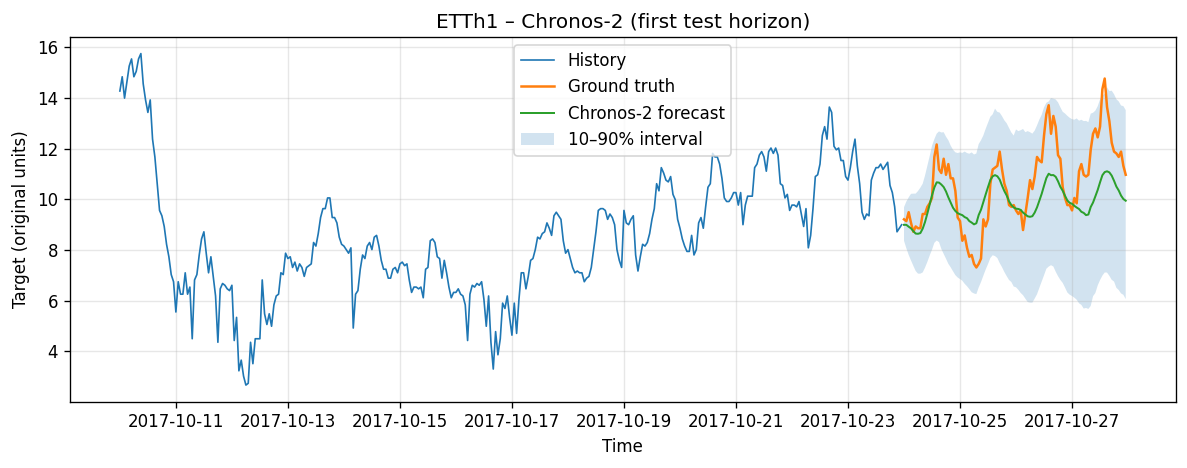

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1


[ETTh1] Chronos-2 – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.021393
MAE (scaled): 0.114201
DTW (scaled): 9.930029
TDI (scaled): 0.164855


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE               │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │  921 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 921 K                                                                                            
Non-trainable params: 3                                                                                            
Total params: 921 K                                                                                                
Total estimated model params size (MB): 3                                                                          
Modules in train mode: 90                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train  │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler        │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ decomp        │ SeriesDecomp  │      0 │ train │     0 │
│ 4 │ linear_trend  │ Linear        │ 32.4 K │ train │     0 │
│ 5 │ linear_season │ Linear        │ 32.4 K │ train │     0 │
└───┴───────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 64.7 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 64.7 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 8                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃    ┃ Name              ┃ Type                 ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0  │ loss              │ MAE                  │      0 │ train │     0 │
│ 1  │ padder_train      │ ConstantPad1d        │      0 │ train │     0 │
│ 2  │ scaler            │ TemporalNorm         │      0 │ train │     0 │
│ 3  │ pdm_blocks        │ ModuleList           │  1.0 M │ train │     0 │
│ 4  │ preprocess        │ SeriesDecomp         │      0 │ train │     0 │
│ 5  │ enc_embedding     │ DataEmbedding_wo_pos │  2.5 K │ train │     0 │
│ 6  │ normalize_layers  │ ModuleList           │      4 │ train │     0 │
│ 7  │ predict_layers    │ ModuleList           │ 48.6 K │ train │     0 │
│ 8  │ projection_layer  │ Linear               │     33 │ train │     0 │
│ 9  │ out_res_layers    │ ModuleList           │  141 K │ train │     0 │
│ 10 │ regression_layers │ ModuleList           │ 48.6 K │ train │     0 │
└────┴───────────────────┴──────────────────────┴────────┴───────┴───────┘

Trainable params: 1.3 M                                                                                            
Non-trainable params: 2.4 K                                                                                        
Total params: 1.3 M                                                                                                
Total estimated model params size (MB): 5                                                                          
Modules in train mode: 138                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type                   ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ MAE                    │      0 │ train │     0 │
│ 1 │ padder_train  │ ConstantPad1d          │      0 │ train │     0 │
│ 2 │ scaler        │ TemporalNorm           │      0 │ train │     0 │
│ 3 │ enc_embedding │ DataEmbedding_inverted │  172 K │ train │     0 │
│ 4 │ encoder       │ TransEncoder           │  6.3 M │ train │     0 │
│ 5 │ projector     │ Linear                 │ 49.2 K │ train │     0 │
└───┴───────────────┴────────────────────────┴────────┴───────┴───────┘

Trainable params: 6.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 6.5 M                                                                                                
Total estimated model params size (MB): 26                                                                         
Modules in train mode: 36                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

Saved plot to: results/h96/ETTh1_PatchTST_h96.png


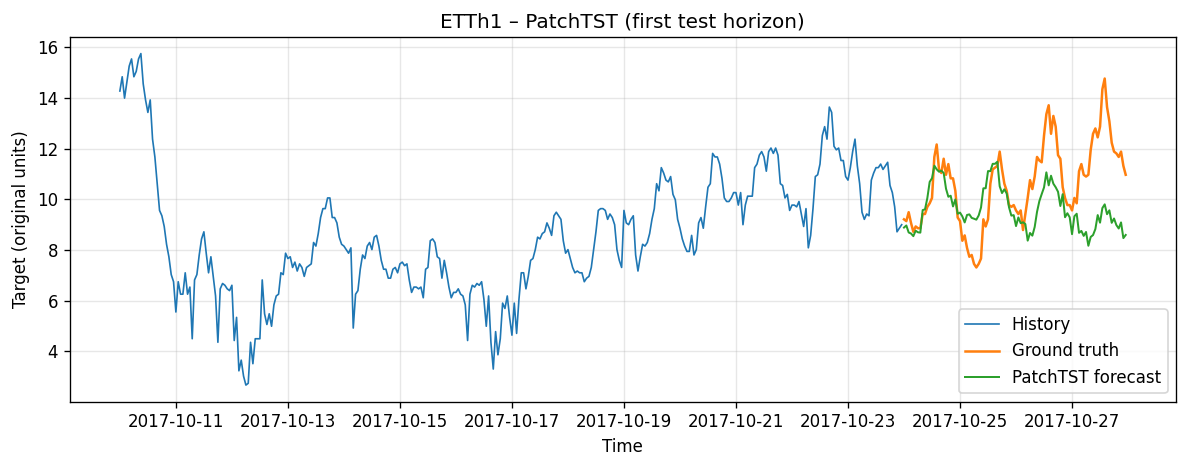

[ETTh1] PatchTST – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.041880
MAE (scaled): 0.156076
DTW (scaled): 12.239693
TDI (scaled): 0.022064
Saved plot to: results/h96/ETTh1_DLinear_h96.png


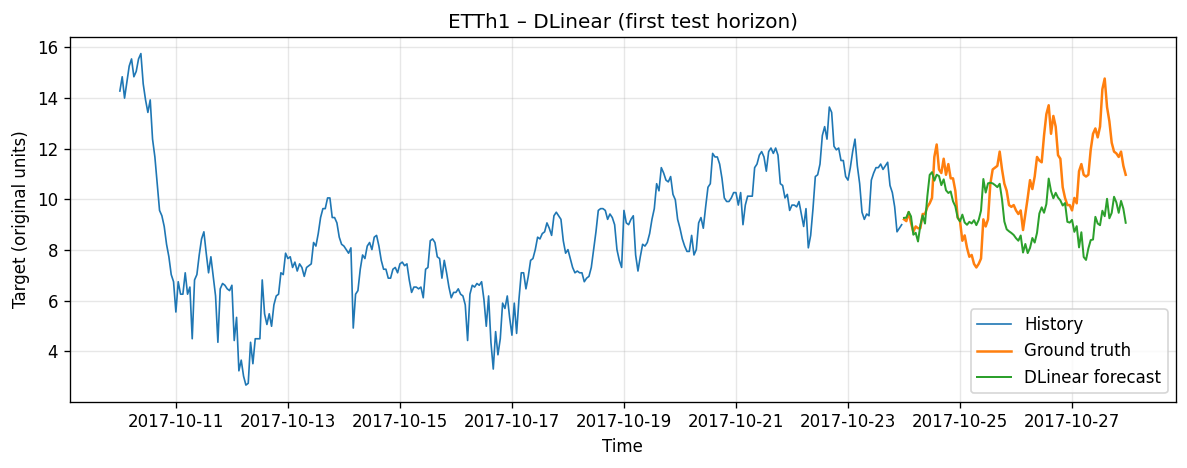

[ETTh1] DLinear – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.046791
MAE (scaled): 0.172619
DTW (scaled): 13.107828
TDI (scaled): 0.085300
Saved plot to: results/h96/ETTh1_TimeMixer_h96.png


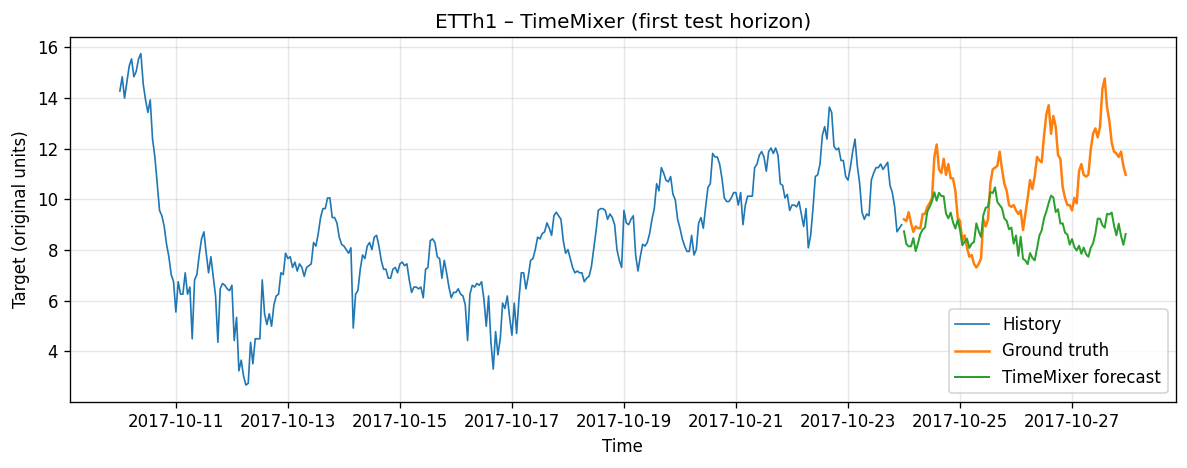

[ETTh1] TimeMixer – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.062007
MAE (scaled): 0.204842
DTW (scaled): 16.314933
TDI (scaled): 0.026240
Saved plot to: results/h96/ETTh1_iTransformer_h96.png


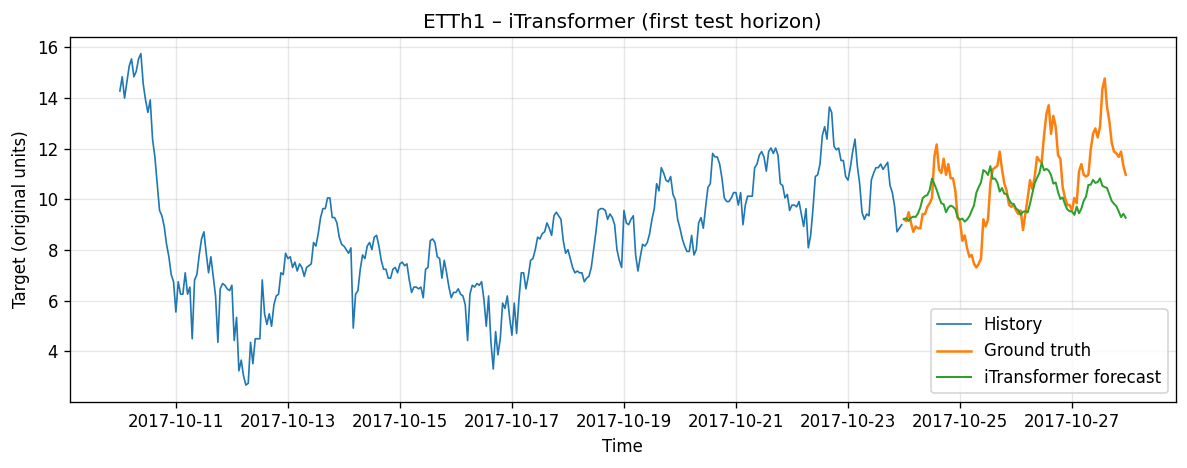

[ETTh1] iTransformer – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.027472
MAE (scaled): 0.128828
DTW (scaled): 8.850396
TDI (scaled): 0.028918

Dataset: ETTm1
[ETTm1] INFO: dataset length 69680 > LTSF total 57600. Using first 57600 points and ignoring extra tail.
Using columns for quantiles -> lower: 0.1, median: predictions, upper: 0.9
Saved plot to: results/h96/ETTm1_Chronos-2_h96.png


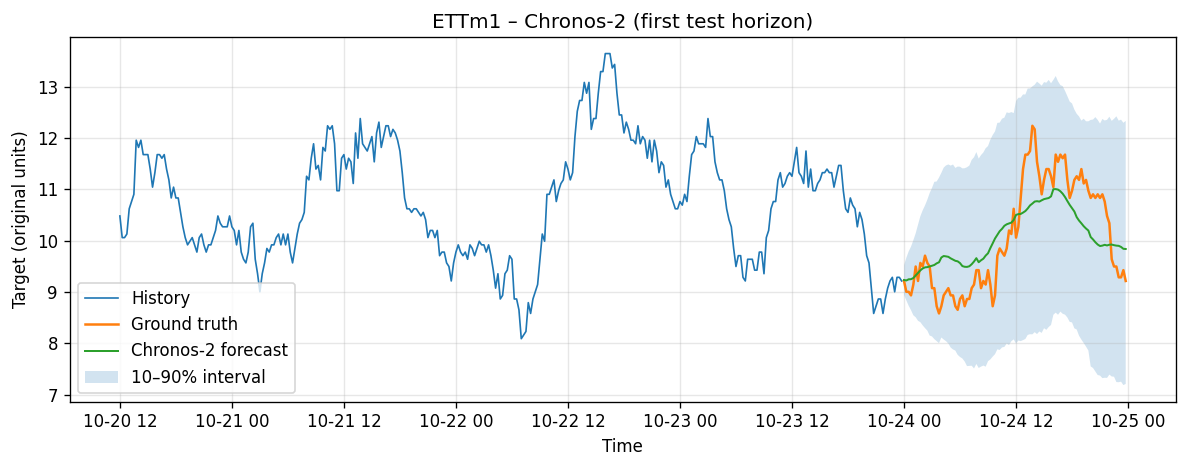

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1


[ETTm1] Chronos-2 – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.005150
MAE (scaled): 0.062643
DTW (scaled): 4.032825
TDI (scaled): 0.115411


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE               │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │  921 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 921 K                                                                                            
Non-trainable params: 3                                                                                            
Total params: 921 K                                                                                                
Total estimated model params size (MB): 3                                                                          
Modules in train mode: 90                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train  │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler        │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ decomp        │ SeriesDecomp  │      0 │ train │     0 │
│ 4 │ linear_trend  │ Linear        │ 32.4 K │ train │     0 │
│ 5 │ linear_season │ Linear        │ 32.4 K │ train │     0 │
└───┴───────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 64.7 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 64.7 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 8                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃    ┃ Name              ┃ Type                 ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0  │ loss              │ MAE                  │      0 │ train │     0 │
│ 1  │ padder_train      │ ConstantPad1d        │      0 │ train │     0 │
│ 2  │ scaler            │ TemporalNorm         │      0 │ train │     0 │
│ 3  │ pdm_blocks        │ ModuleList           │  1.0 M │ train │     0 │
│ 4  │ preprocess        │ SeriesDecomp         │      0 │ train │     0 │
│ 5  │ enc_embedding     │ DataEmbedding_wo_pos │  2.5 K │ train │     0 │
│ 6  │ normalize_layers  │ ModuleList           │      4 │ train │     0 │
│ 7  │ predict_layers    │ ModuleList           │ 48.6 K │ train │     0 │
│ 8  │ projection_layer  │ Linear               │     33 │ train │     0 │
│ 9  │ out_res_layers    │ ModuleList           │  141 K │ train │     0 │
│ 10 │ regression_layers │ ModuleList           │ 48.6 K │ train │     0 │
└────┴───────────────────┴──────────────────────┴────────┴───────┴───────┘

Trainable params: 1.3 M                                                                                            
Non-trainable params: 2.4 K                                                                                        
Total params: 1.3 M                                                                                                
Total estimated model params size (MB): 5                                                                          
Modules in train mode: 138                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type                   ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ MAE                    │      0 │ train │     0 │
│ 1 │ padder_train  │ ConstantPad1d          │      0 │ train │     0 │
│ 2 │ scaler        │ TemporalNorm           │      0 │ train │     0 │
│ 3 │ enc_embedding │ DataEmbedding_inverted │  172 K │ train │     0 │
│ 4 │ encoder       │ TransEncoder           │  6.3 M │ train │     0 │
│ 5 │ projector     │ Linear                 │ 49.2 K │ train │     0 │
└───┴───────────────┴────────────────────────┴────────┴───────┴───────┘

Trainable params: 6.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 6.5 M                                                                                                
Total estimated model params size (MB): 26                                                                         
Modules in train mode: 36                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

Saved plot to: results/h96/ETTm1_PatchTST_h96.png


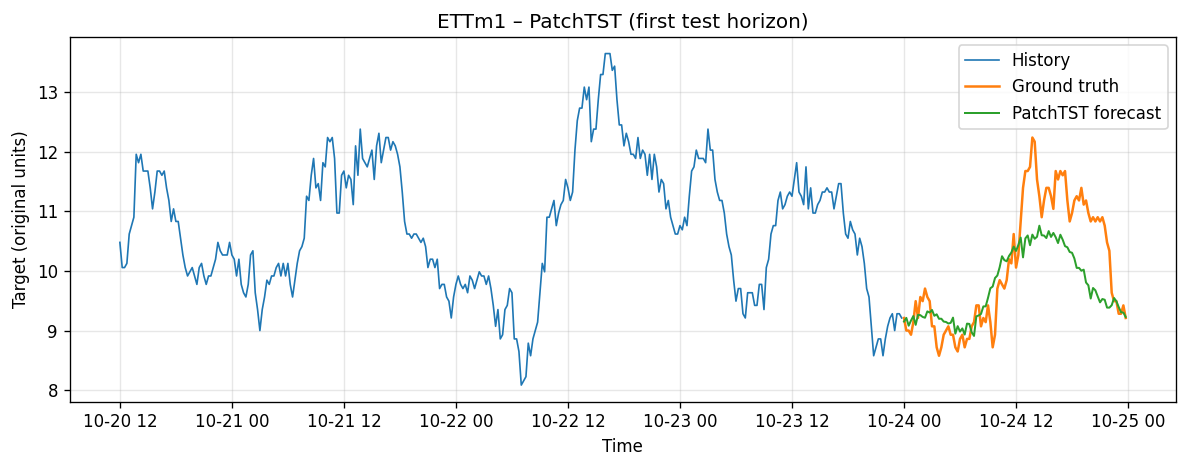

[ETTm1] PatchTST – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.006378
MAE (scaled): 0.061879
DTW (scaled): 3.602343
TDI (scaled): 0.076841
Saved plot to: results/h96/ETTm1_DLinear_h96.png


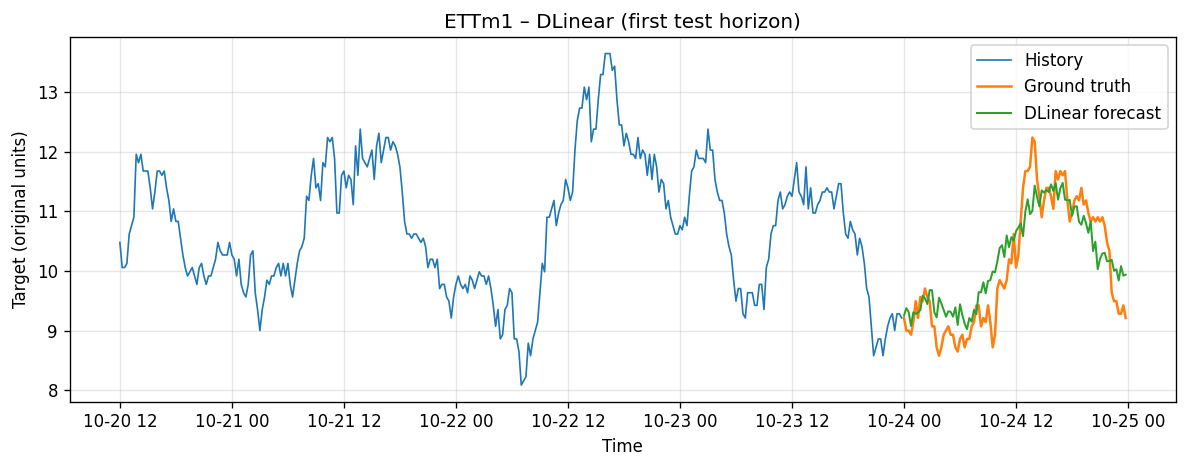

[ETTm1] DLinear – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.002773
MAE (scaled): 0.043963
DTW (scaled): 2.475588
TDI (scaled): 0.039833
Saved plot to: results/h96/ETTm1_TimeMixer_h96.png


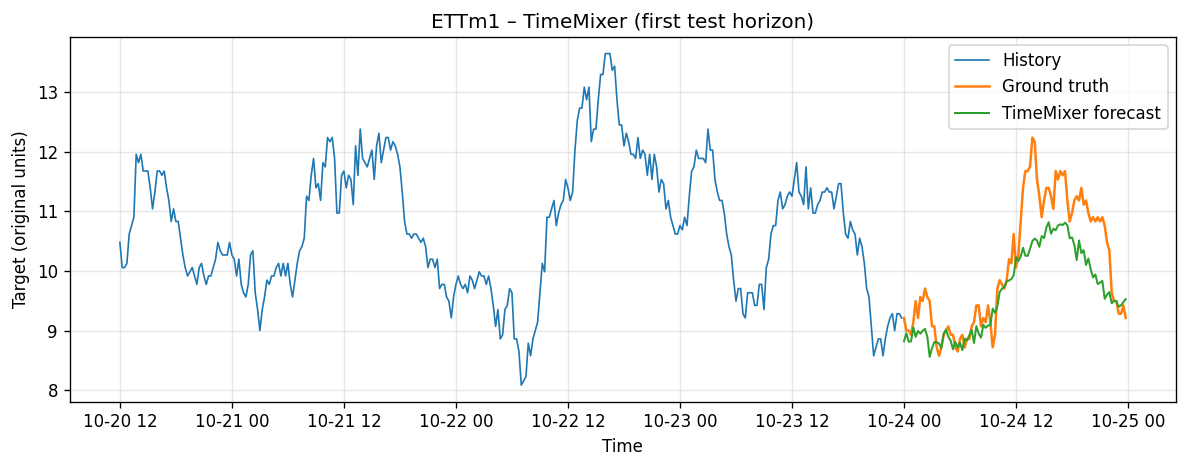

[ETTm1] TimeMixer – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.005043
MAE (scaled): 0.054317
DTW (scaled): 3.405932
TDI (scaled): 0.049802
Saved plot to: results/h96/ETTm1_iTransformer_h96.png


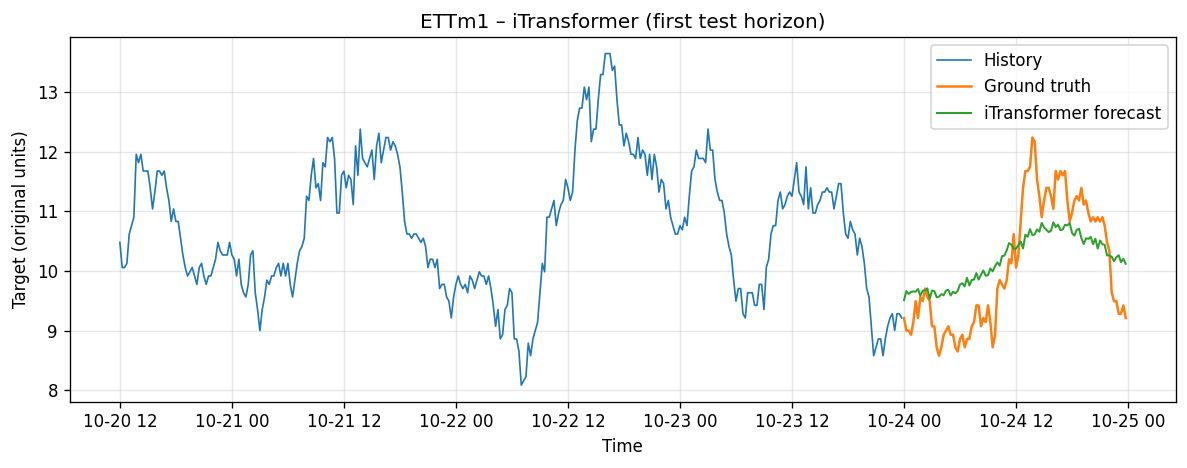

[ETTm1] iTransformer – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.005901
MAE (scaled): 0.068016
DTW (scaled): 5.380457
TDI (scaled): 0.077303

Dataset: ETTm2
[ETTm2] INFO: dataset length 69680 > LTSF total 57600. Using first 57600 points and ignoring extra tail.
Using columns for quantiles -> lower: 0.1, median: predictions, upper: 0.9
Saved plot to: results/h96/ETTm2_Chronos-2_h96.png


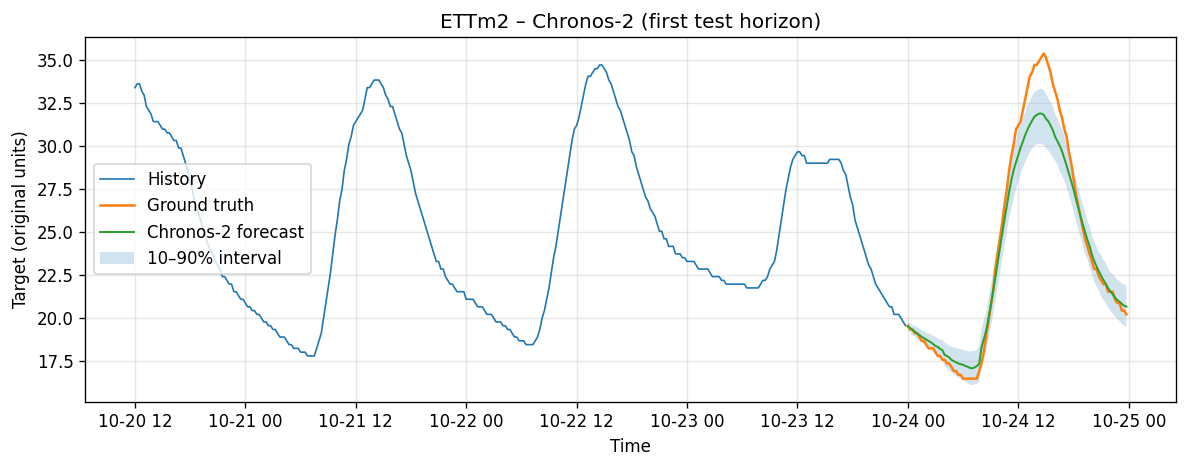

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1


[ETTm2] Chronos-2 – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.013779
MAE (scaled): 0.081038
DTW (scaled): 4.553688
TDI (scaled): 0.026173


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE               │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │  921 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 921 K                                                                                            
Non-trainable params: 3                                                                                            
Total params: 921 K                                                                                                
Total estimated model params size (MB): 3                                                                          
Modules in train mode: 90                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train  │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler        │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ decomp        │ SeriesDecomp  │      0 │ train │     0 │
│ 4 │ linear_trend  │ Linear        │ 32.4 K │ train │     0 │
│ 5 │ linear_season │ Linear        │ 32.4 K │ train │     0 │
└───┴───────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 64.7 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 64.7 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 8                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃    ┃ Name              ┃ Type                 ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0  │ loss              │ MAE                  │      0 │ train │     0 │
│ 1  │ padder_train      │ ConstantPad1d        │      0 │ train │     0 │
│ 2  │ scaler            │ TemporalNorm         │      0 │ train │     0 │
│ 3  │ pdm_blocks        │ ModuleList           │  1.0 M │ train │     0 │
│ 4  │ preprocess        │ SeriesDecomp         │      0 │ train │     0 │
│ 5  │ enc_embedding     │ DataEmbedding_wo_pos │  2.5 K │ train │     0 │
│ 6  │ normalize_layers  │ ModuleList           │      4 │ train │     0 │
│ 7  │ predict_layers    │ ModuleList           │ 48.6 K │ train │     0 │
│ 8  │ projection_layer  │ Linear               │     33 │ train │     0 │
│ 9  │ out_res_layers    │ ModuleList           │  141 K │ train │     0 │
│ 10 │ regression_layers │ ModuleList           │ 48.6 K │ train │     0 │
└────┴───────────────────┴──────────────────────┴────────┴───────┴───────┘

Trainable params: 1.3 M                                                                                            
Non-trainable params: 2.4 K                                                                                        
Total params: 1.3 M                                                                                                
Total estimated model params size (MB): 5                                                                          
Modules in train mode: 138                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type                   ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ MAE                    │      0 │ train │     0 │
│ 1 │ padder_train  │ ConstantPad1d          │      0 │ train │     0 │
│ 2 │ scaler        │ TemporalNorm           │      0 │ train │     0 │
│ 3 │ enc_embedding │ DataEmbedding_inverted │  172 K │ train │     0 │
│ 4 │ encoder       │ TransEncoder           │  6.3 M │ train │     0 │
│ 5 │ projector     │ Linear                 │ 49.2 K │ train │     0 │
└───┴───────────────┴────────────────────────┴────────┴───────┴───────┘

Trainable params: 6.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 6.5 M                                                                                                
Total estimated model params size (MB): 26                                                                         
Modules in train mode: 36                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

Saved plot to: results/h96/ETTm2_PatchTST_h96.png


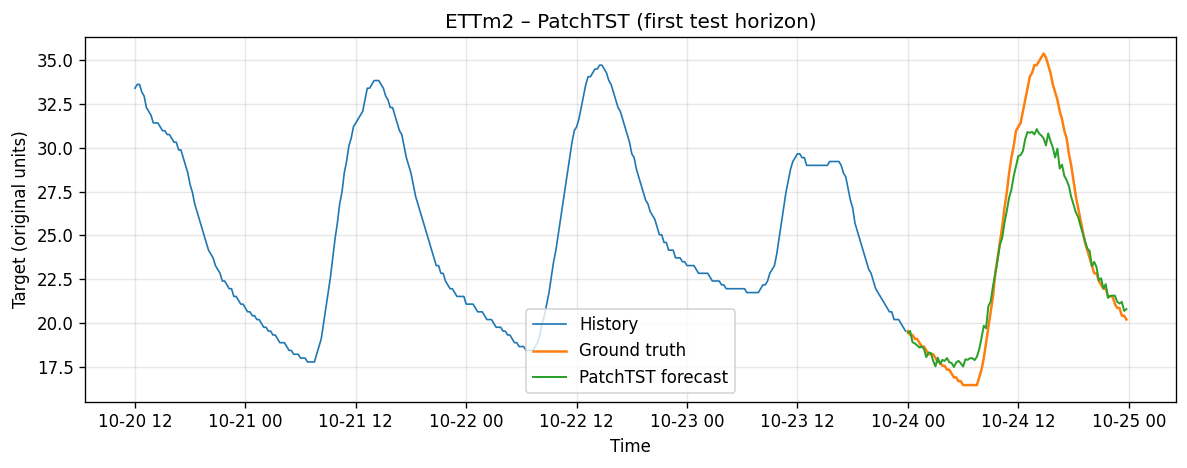

[ETTm2] PatchTST – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.024207
MAE (scaled): 0.109387
DTW (scaled): 6.833055
TDI (scaled): 0.033193
Saved plot to: results/h96/ETTm2_DLinear_h96.png


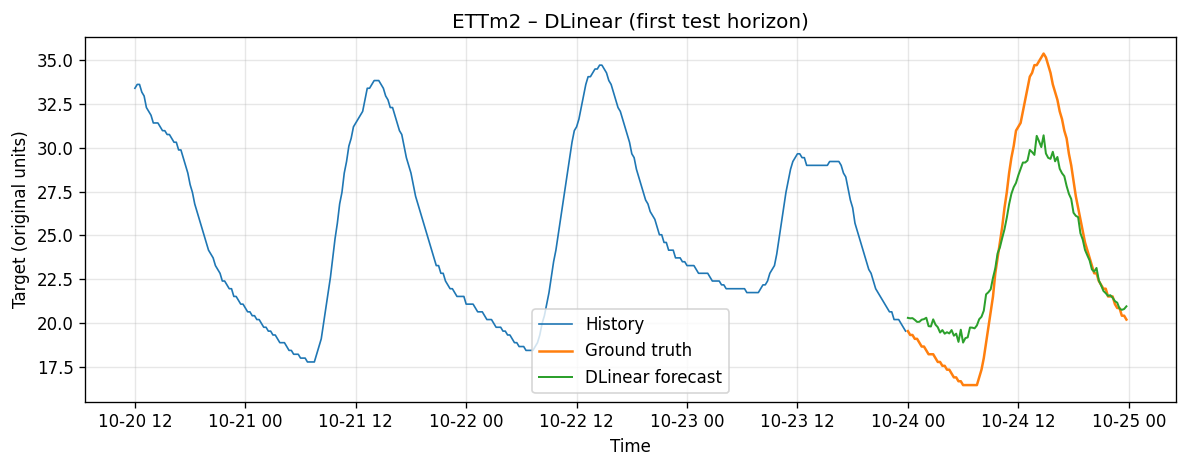

[ETTm2] DLinear – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.045676
MAE (scaled): 0.172852
DTW (scaled): 10.838877
TDI (scaled): 0.061787
Saved plot to: results/h96/ETTm2_TimeMixer_h96.png


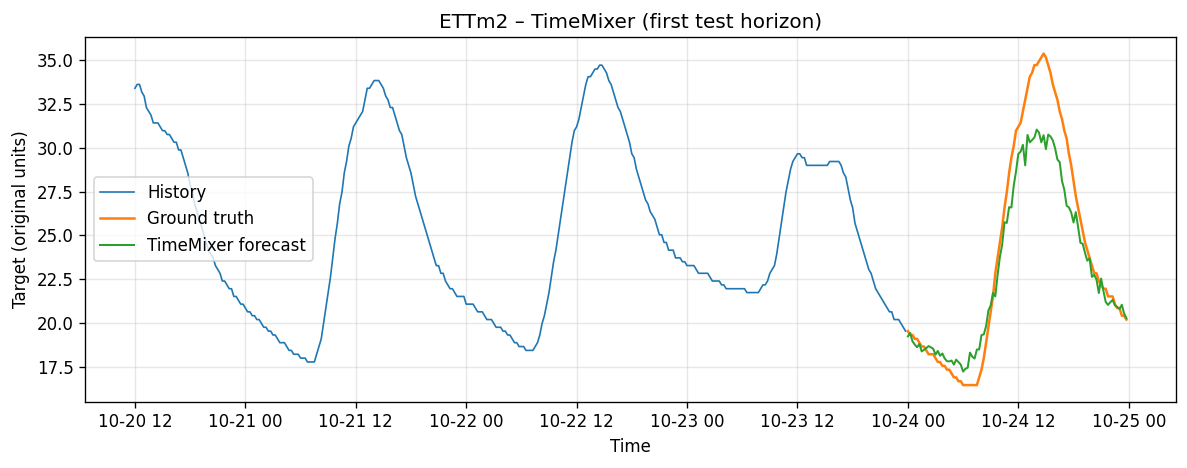

[ETTm2] TimeMixer – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.029365
MAE (scaled): 0.125449
DTW (scaled): 6.642867
TDI (scaled): 0.037080
Saved plot to: results/h96/ETTm2_iTransformer_h96.png


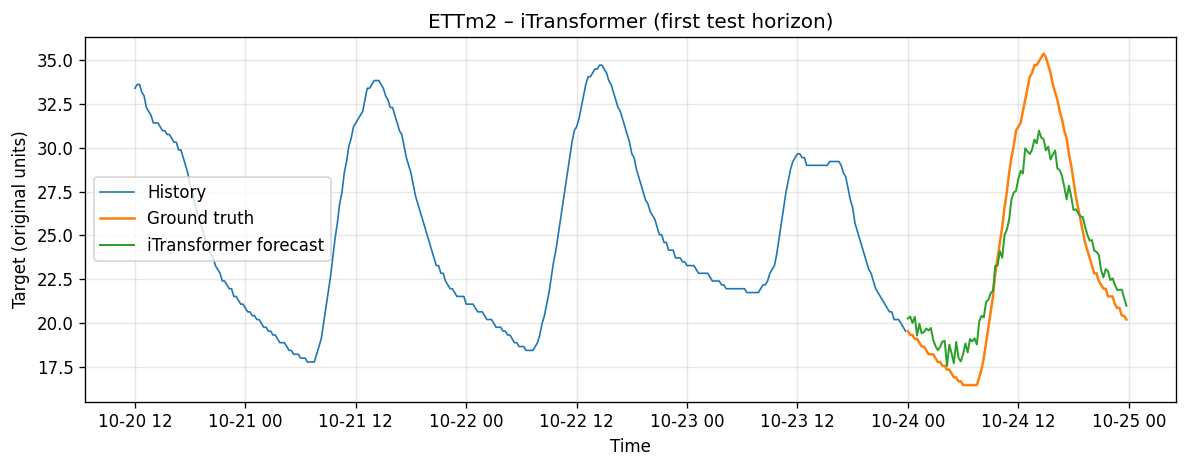

[ETTm2] iTransformer – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.040728
MAE (scaled): 0.167619
DTW (scaled): 8.005553
TDI (scaled): 0.054493

Dataset: Weather
[Weather] WARNING: irregular timestamps; using regular freq '10min'
[Weather] INFO: dataset length 52696 > LTSF total 52603. Using first 52603 points and ignoring extra tail.
Using columns for quantiles -> lower: 0.1, median: predictions, upper: 0.9
Saved plot to: results/h96/Weather_Chronos-2_h96.png


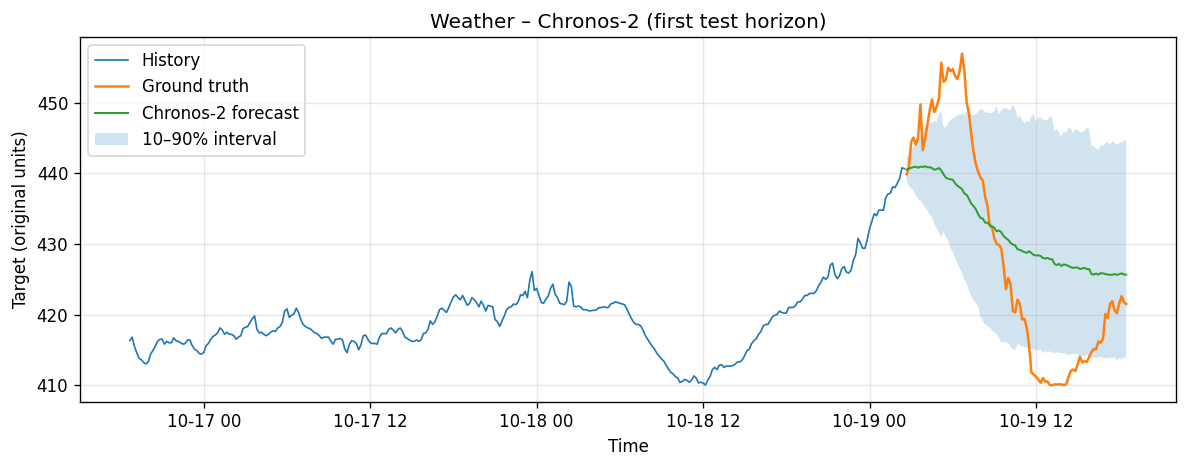

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1


[Weather] Chronos-2 – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.000874
MAE (scaled): 0.025876
DTW (scaled): 2.133311
TDI (scaled): 0.129621


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE               │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │  921 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 921 K                                                                                            
Non-trainable params: 3                                                                                            
Total params: 921 K                                                                                                
Total estimated model params size (MB): 3                                                                          
Modules in train mode: 90                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train  │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler        │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ decomp        │ SeriesDecomp  │      0 │ train │     0 │
│ 4 │ linear_trend  │ Linear        │ 32.4 K │ train │     0 │
│ 5 │ linear_season │ Linear        │ 32.4 K │ train │     0 │
└───┴───────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 64.7 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 64.7 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 8                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃    ┃ Name              ┃ Type                 ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0  │ loss              │ MAE                  │      0 │ train │     0 │
│ 1  │ padder_train      │ ConstantPad1d        │      0 │ train │     0 │
│ 2  │ scaler            │ TemporalNorm         │      0 │ train │     0 │
│ 3  │ pdm_blocks        │ ModuleList           │  1.0 M │ train │     0 │
│ 4  │ preprocess        │ SeriesDecomp         │      0 │ train │     0 │
│ 5  │ enc_embedding     │ DataEmbedding_wo_pos │  2.5 K │ train │     0 │
│ 6  │ normalize_layers  │ ModuleList           │      4 │ train │     0 │
│ 7  │ predict_layers    │ ModuleList           │ 48.6 K │ train │     0 │
│ 8  │ projection_layer  │ Linear               │     33 │ train │     0 │
│ 9  │ out_res_layers    │ ModuleList           │  141 K │ train │     0 │
│ 10 │ regression_layers │ ModuleList           │ 48.6 K │ train │     0 │
└────┴───────────────────┴──────────────────────┴────────┴───────┴───────┘

Trainable params: 1.3 M                                                                                            
Non-trainable params: 2.4 K                                                                                        
Total params: 1.3 M                                                                                                
Total estimated model params size (MB): 5                                                                          
Modules in train mode: 138                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type                   ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ MAE                    │      0 │ train │     0 │
│ 1 │ padder_train  │ ConstantPad1d          │      0 │ train │     0 │
│ 2 │ scaler        │ TemporalNorm           │      0 │ train │     0 │
│ 3 │ enc_embedding │ DataEmbedding_inverted │  172 K │ train │     0 │
│ 4 │ encoder       │ TransEncoder           │  6.3 M │ train │     0 │
│ 5 │ projector     │ Linear                 │ 49.2 K │ train │     0 │
└───┴───────────────┴────────────────────────┴────────┴───────┴───────┘

Trainable params: 6.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 6.5 M                                                                                                
Total estimated model params size (MB): 26                                                                         
Modules in train mode: 36                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

Saved plot to: results/h96/Weather_PatchTST_h96.png


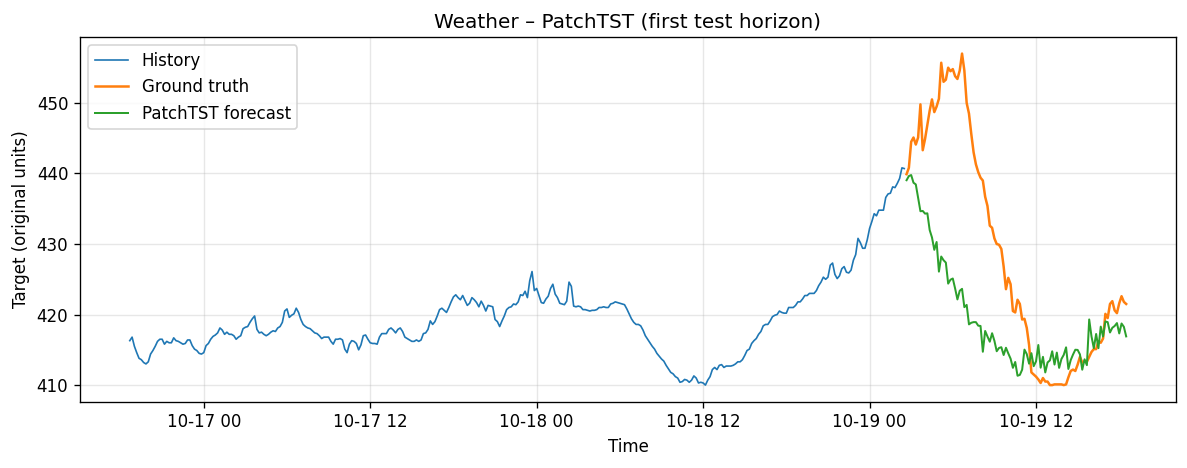

[Weather] PatchTST – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.001474
MAE (scaled): 0.027905
DTW (scaled): 1.052360
TDI (scaled): 0.156675
Saved plot to: results/h96/Weather_DLinear_h96.png


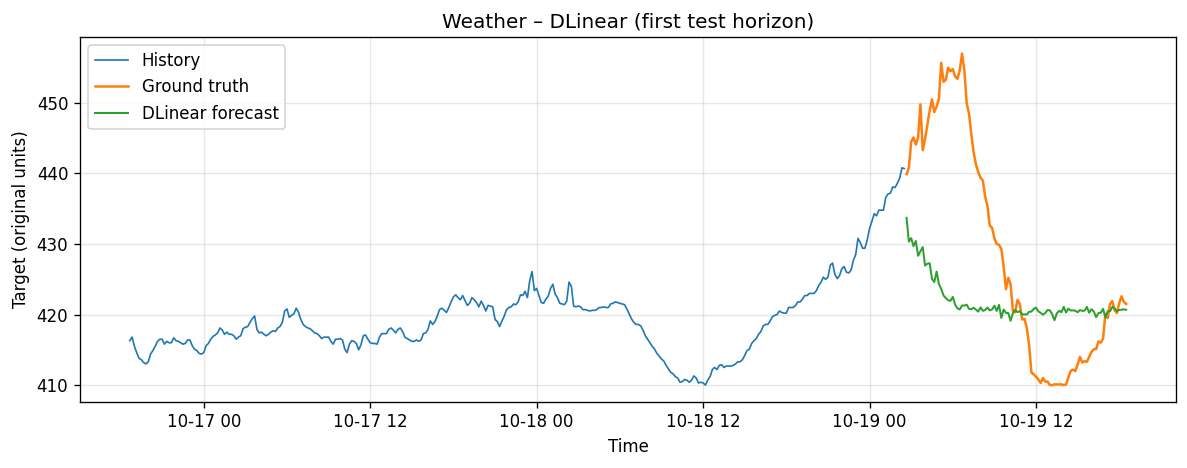

[Weather] DLinear – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.001746
MAE (scaled): 0.032615
DTW (scaled): 2.058798
TDI (scaled): 0.221143
Saved plot to: results/h96/Weather_TimeMixer_h96.png


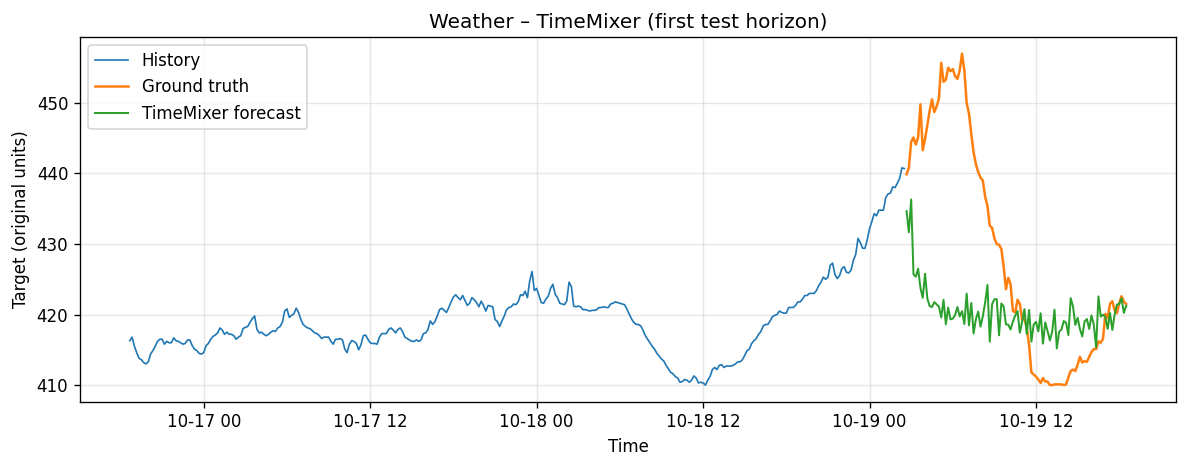

[Weather] TimeMixer – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.001961
MAE (scaled): 0.033162
DTW (scaled): 1.695304
TDI (scaled): 0.140039
Saved plot to: results/h96/Weather_iTransformer_h96.png


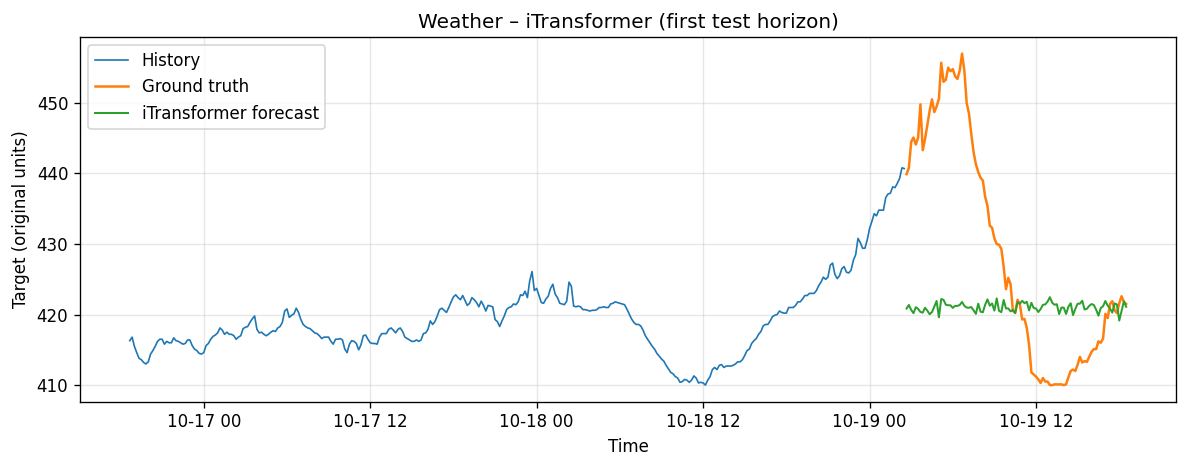

[Weather] iTransformer – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.002114
MAE (scaled): 0.036363
DTW (scaled): 3.396961
TDI (scaled): 0.172902
Saved metrics CSV to: results/h96/metrics_h96.csv


dataset         model  mse_scaled  mae_scaled  dtw_scaled  tdi_scaled  \
0     ETTh1     Chronos-2    0.021393    0.114201    9.930029    0.164855   
1     ETTh1      PatchTST    0.041880    0.156076   12.239693    0.022064   
2     ETTh1       DLinear    0.046791    0.172619   13.107828    0.085300   
3     ETTh1     TimeMixer    0.062007    0.204842   16.314933    0.026240   
4     ETTh1  iTransformer    0.027472    0.128828    8.850396    0.028918   
5     ETTm1     Chronos-2    0.005150    0.062643    4.032825    0.115411   
6     ETTm1      PatchTST    0.006378    0.061879    3.602343    0.076841   
7     ETTm1       DLinear    0.002773    0.043963    2.475588    0.039833   
8     ETTm1     TimeMixer    0.005043    0.054317    3.405932    0.049802   
9     ETTm1  iTransformer    0.005901    0.068016    5.380457    0.077303   
10    ETTm2     Chronos-2    0.013779    0.081038    4.553688    0.026173   
11    ETTm2      PatchTST    0.024207    0.109387    6.833055    0.033193   
12    ETTm2       DLinear    0.045676    0.172852   10.838877    0.061787   
13    ETTm2     TimeMixer    0.029365    0.125449    6.642867    0.037080   
14    ETTm2  iTransformer    0.040728    0.167619    8.005553    0.054493   
15  Weather     Chronos-2    0.000874    0.025876    2.133311    0.129621   
16  Weather      PatchTST    0.001474    0.027905    1.052360    0.156675   
17  Weather       DLinear    0.001746    0.032615    2.058798    0.221143   
18  Weather     TimeMixer    0.001961    0.033162    1.695304    0.140039   
19  Weather  iTransformer    0.002114    0.036363    3.396961    0.172902   

                 protocol  
0   single_horizon_scaled  
1   single_horizon_scaled  
2   single_horizon_scaled  
3   single_horizon_scaled  
4   single_horizon_scaled  
5   single_horizon_scaled  
6   single_horizon_scaled  
7   single_horizon_scaled  
8   single_horizon_scaled  
9   single_horizon_scaled  
10  single_horizon_scaled  
11  single_horizon_scaled  
12  single_horizon_scaled  
13  single_horizon_scaled  
14  single_horizon_scaled  
15  single_horizon_scaled  
16  single_horizon_scaled  
17  single_horizon_scaled  
18  single_horizon_scaled  
19  single_horizon_scaled

In [ ]:
PREDICTION_LENGTH = 96
all_results = []

RESULTS_SUBDIR = os.path.join(BASE_RESULTS_DIR, f"h{PREDICTION_LENGTH}")
os.makedirs(RESULTS_SUBDIR, exist_ok=True)
print("Saving results to:", RESULTS_SUBDIR)

for ds_name, path in DATASETS.items():
    print("\n" + "=" * 80)
    print(f"Dataset: {ds_name}")
    dataset = prepare_dataset(ds_name, path)

    # Chronos-2
    chr_pred_scaled, chr_lower_scaled, chr_upper_scaled = chronos_predict_scaled(
        dataset, pipeline
    )
    res = plot_and_metrics(
        dataset,
        "Chronos-2",
        chr_pred_scaled,
        lower_scaled=chr_lower_scaled,
        upper_scaled=chr_upper_scaled,
        results_dir=RESULTS_SUBDIR,
    )
    all_results.append(res)

    # NeuralForecast models
    nf_preds = nf_predict_scaled(dataset)
    for model_name, pred_scaled in nf_preds.items():
        res = plot_and_metrics(
            dataset,
            model_name,
            pred_scaled,
            results_dir=RESULTS_SUBDIR,
        )
        all_results.append(res)

metrics_df = pd.DataFrame(all_results)

csv_path = os.path.join(RESULTS_SUBDIR, f"metrics_h{PREDICTION_LENGTH}.csv")
metrics_df.to_csv(csv_path, index=False)
print("Saved metrics CSV to:", csv_path)

metrics_df

Saving results to: results/h336

Dataset: ETTh1
[ETTh1] INFO: dataset length 17420 > LTSF total 14400. Using first 14400 points and ignoring extra tail.
Using columns for quantiles -> lower: 0.1, median: predictions, upper: 0.9
Saved plot to: results/h336/ETTh1_Chronos-2_h336.png


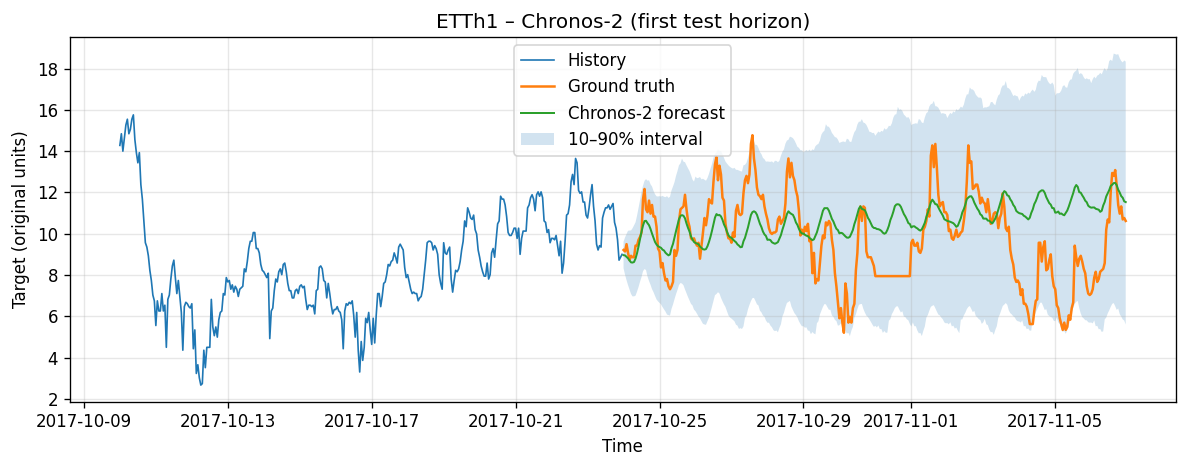

INFO:lightning_fabric.utilities.seed:Seed set to 1


[ETTh1] Chronos-2 – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.062555
MAE (scaled): 0.193180
DTW (scaled): 56.808214
TDI (scaled): 0.154187


INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE               │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │  2.2 M │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 2.2 M                                                                                            
Non-trainable params: 3                                                                                            
Total params: 2.2 M                                                                                                
Total estimated model params size (MB): 8                                                                          
Modules in train mode: 90                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train  │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler        │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ decomp        │ SeriesDecomp  │      0 │ train │     0 │
│ 4 │ linear_trend  │ Linear        │  113 K │ train │     0 │
│ 5 │ linear_season │ Linear        │  113 K │ train │     0 │
└───┴───────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 226 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 226 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 8                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃    ┃ Name              ┃ Type                 ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0  │ loss              │ MAE                  │      0 │ train │     0 │
│ 1  │ padder_train      │ ConstantPad1d        │      0 │ train │     0 │
│ 2  │ scaler            │ TemporalNorm         │      0 │ train │     0 │
│ 3  │ pdm_blocks        │ ModuleList           │  1.0 M │ train │     0 │
│ 4  │ preprocess        │ SeriesDecomp         │      0 │ train │     0 │
│ 5  │ enc_embedding     │ DataEmbedding_wo_pos │  2.5 K │ train │     0 │
│ 6  │ normalize_layers  │ ModuleList           │      4 │ train │     0 │
│ 7  │ predict_layers    │ ModuleList           │  170 K │ train │     0 │
│ 8  │ projection_layer  │ Linear               │     33 │ train │     0 │
│ 9  │ out_res_layers    │ ModuleList           │  141 K │ train │     0 │
│ 10 │ regression_layers │ ModuleList           │  170 K │ train │     0 │
└────┴───────────────────┴──────────────────────┴────────┴───────┴───────┘

Trainable params: 1.5 M                                                                                            
Non-trainable params: 2.4 K                                                                                        
Total params: 1.5 M                                                                                                
Total estimated model params size (MB): 6                                                                          
Modules in train mode: 138                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type                   ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ MAE                    │      0 │ train │     0 │
│ 1 │ padder_train  │ ConstantPad1d          │      0 │ train │     0 │
│ 2 │ scaler        │ TemporalNorm           │      0 │ train │     0 │
│ 3 │ enc_embedding │ DataEmbedding_inverted │  172 K │ train │     0 │
│ 4 │ encoder       │ TransEncoder           │  6.3 M │ train │     0 │
│ 5 │ projector     │ Linear                 │  172 K │ train │     0 │
└───┴───────────────┴────────────────────────┴────────┴───────┴───────┘

Trainable params: 6.7 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 6.7 M                                                                                                
Total estimated model params size (MB): 26                                                                         
Modules in train mode: 36                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

Saved plot to: results/h336/ETTh1_PatchTST_h336.png


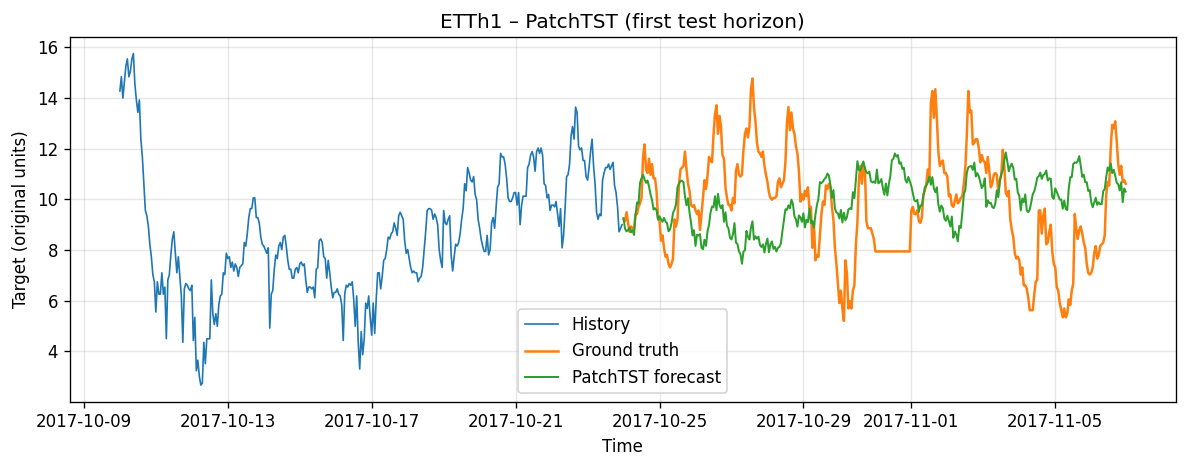

[ETTh1] PatchTST – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.065591
MAE (scaled): 0.214957
DTW (scaled): 37.276441
TDI (scaled): 0.156861
Saved plot to: results/h336/ETTh1_DLinear_h336.png


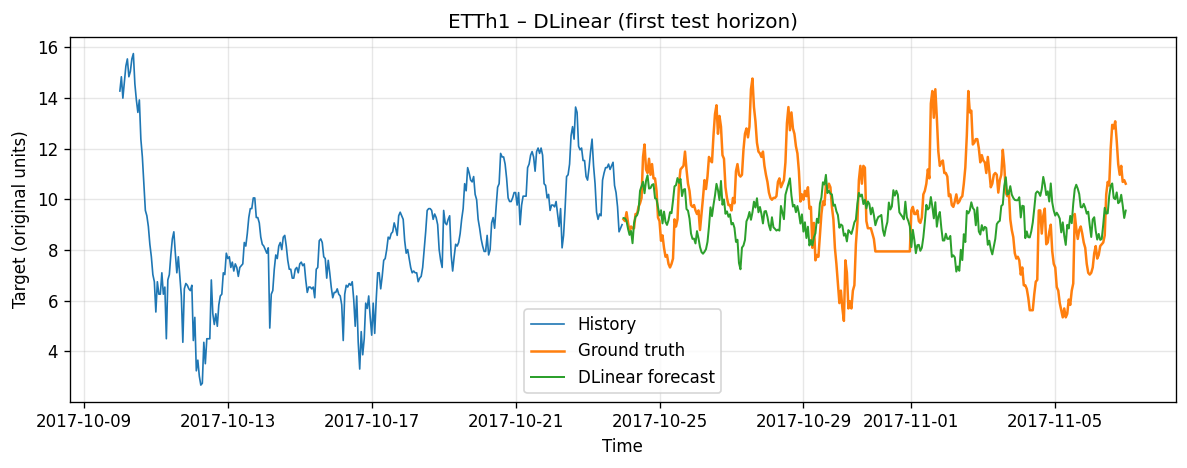

[ETTh1] DLinear – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.050888
MAE (scaled): 0.194467
DTW (scaled): 39.174600
TDI (scaled): 0.121449
Saved plot to: results/h336/ETTh1_TimeMixer_h336.png


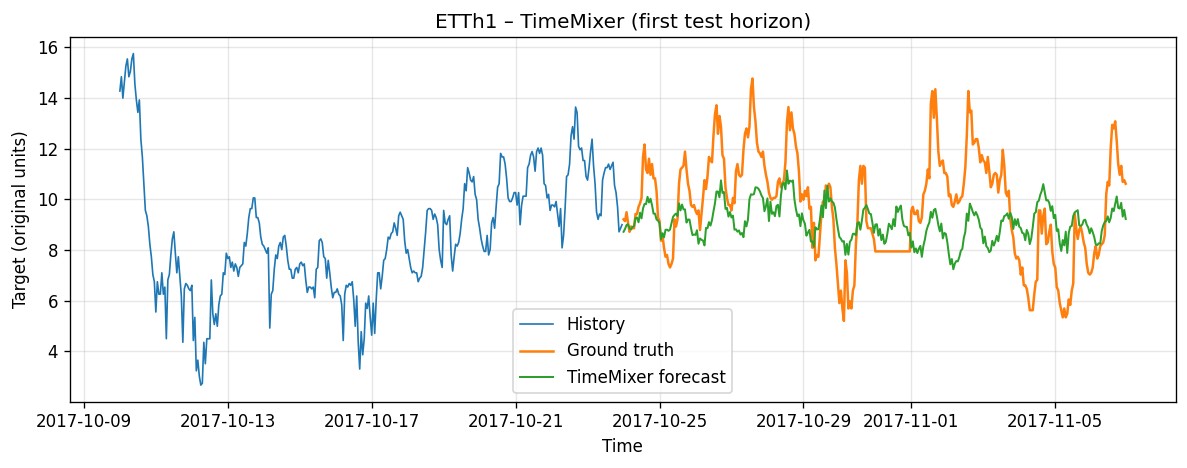

[ETTh1] TimeMixer – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.044372
MAE (scaled): 0.177655
DTW (scaled): 36.967133
TDI (scaled): 0.116545
Saved plot to: results/h336/ETTh1_iTransformer_h336.png


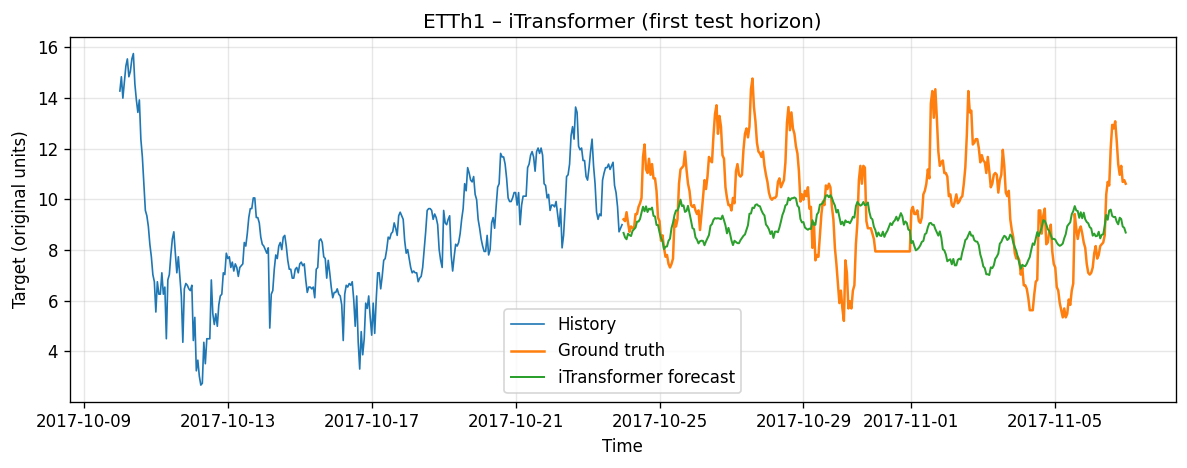

[ETTh1] iTransformer – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.057645
MAE (scaled): 0.198602
DTW (scaled): 44.813601
TDI (scaled): 0.157585

Dataset: ETTm1
[ETTm1] INFO: dataset length 69680 > LTSF total 57600. Using first 57600 points and ignoring extra tail.
Using columns for quantiles -> lower: 0.1, median: predictions, upper: 0.9
Saved plot to: results/h336/ETTm1_Chronos-2_h336.png


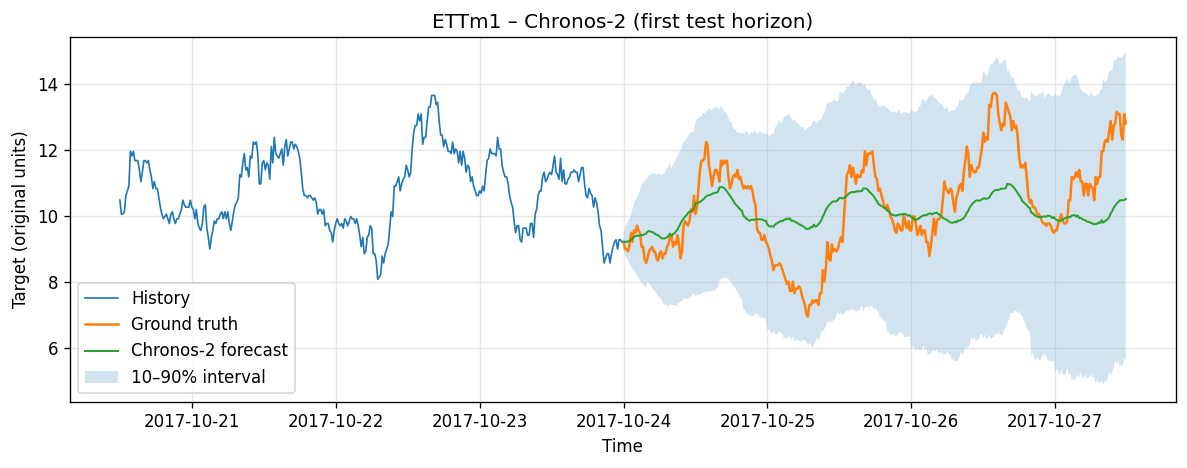

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1


[ETTm1] Chronos-2 – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.018342
MAE (scaled): 0.107346
DTW (scaled): 28.237847
TDI (scaled): 0.039199


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE               │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │  2.2 M │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 2.2 M                                                                                            
Non-trainable params: 3                                                                                            
Total params: 2.2 M                                                                                                
Total estimated model params size (MB): 8                                                                          
Modules in train mode: 90                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train  │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler        │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ decomp        │ SeriesDecomp  │      0 │ train │     0 │
│ 4 │ linear_trend  │ Linear        │  113 K │ train │     0 │
│ 5 │ linear_season │ Linear        │  113 K │ train │     0 │
└───┴───────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 226 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 226 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 8                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃    ┃ Name              ┃ Type                 ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0  │ loss              │ MAE                  │      0 │ train │     0 │
│ 1  │ padder_train      │ ConstantPad1d        │      0 │ train │     0 │
│ 2  │ scaler            │ TemporalNorm         │      0 │ train │     0 │
│ 3  │ pdm_blocks        │ ModuleList           │  1.0 M │ train │     0 │
│ 4  │ preprocess        │ SeriesDecomp         │      0 │ train │     0 │
│ 5  │ enc_embedding     │ DataEmbedding_wo_pos │  2.5 K │ train │     0 │
│ 6  │ normalize_layers  │ ModuleList           │      4 │ train │     0 │
│ 7  │ predict_layers    │ ModuleList           │  170 K │ train │     0 │
│ 8  │ projection_layer  │ Linear               │     33 │ train │     0 │
│ 9  │ out_res_layers    │ ModuleList           │  141 K │ train │     0 │
│ 10 │ regression_layers │ ModuleList           │  170 K │ train │     0 │
└────┴───────────────────┴──────────────────────┴────────┴───────┴───────┘

Trainable params: 1.5 M                                                                                            
Non-trainable params: 2.4 K                                                                                        
Total params: 1.5 M                                                                                                
Total estimated model params size (MB): 6                                                                          
Modules in train mode: 138                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type                   ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ MAE                    │      0 │ train │     0 │
│ 1 │ padder_train  │ ConstantPad1d          │      0 │ train │     0 │
│ 2 │ scaler        │ TemporalNorm           │      0 │ train │     0 │
│ 3 │ enc_embedding │ DataEmbedding_inverted │  172 K │ train │     0 │
│ 4 │ encoder       │ TransEncoder           │  6.3 M │ train │     0 │
│ 5 │ projector     │ Linear                 │  172 K │ train │     0 │
└───┴───────────────┴────────────────────────┴────────┴───────┴───────┘

Trainable params: 6.7 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 6.7 M                                                                                                
Total estimated model params size (MB): 26                                                                         
Modules in train mode: 36                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

Saved plot to: results/h336/ETTm1_PatchTST_h336.png


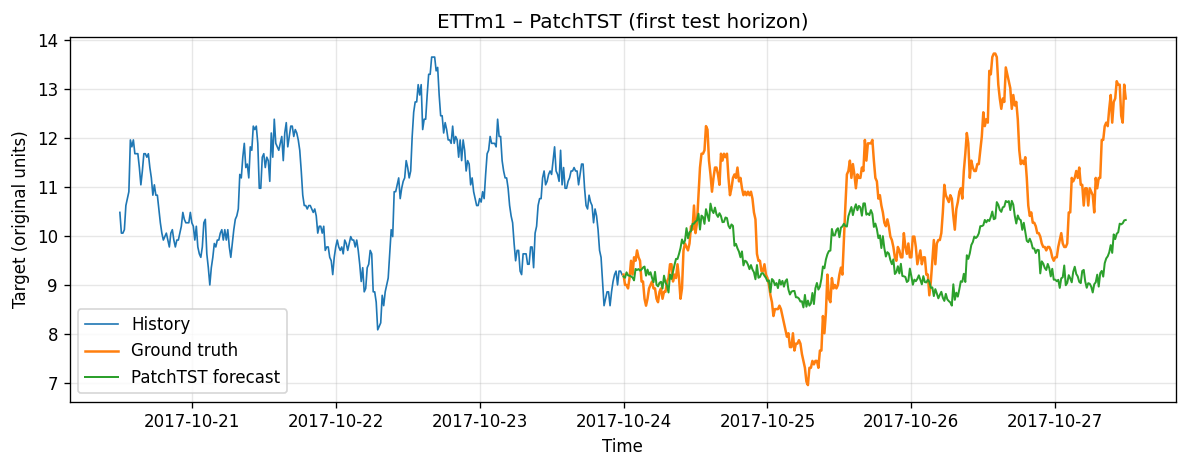

[ETTm1] PatchTST – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.022430
MAE (scaled): 0.121927
DTW (scaled): 25.870987
TDI (scaled): 0.036312
Saved plot to: results/h336/ETTm1_DLinear_h336.png


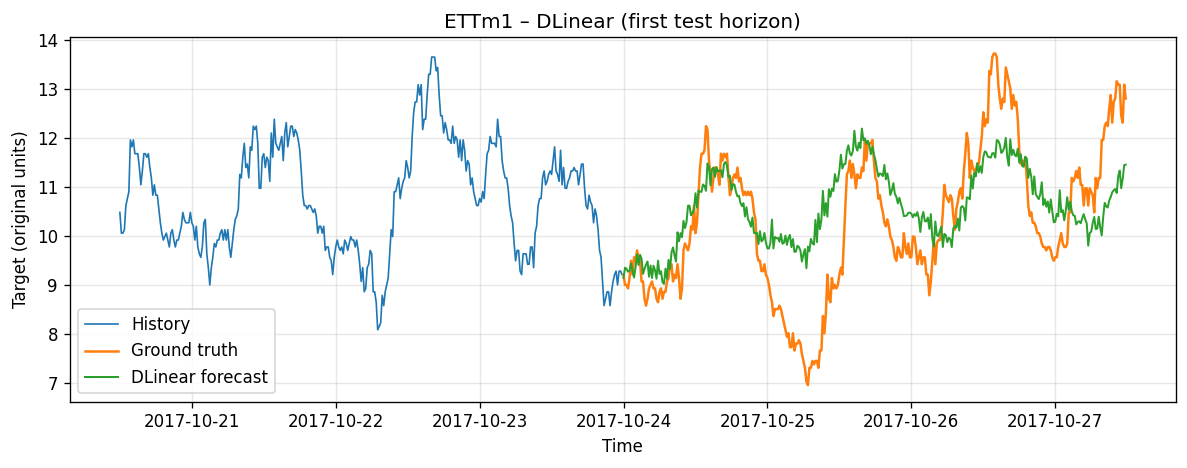

[ETTm1] DLinear – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.014737
MAE (scaled): 0.096397
DTW (scaled): 18.869918
TDI (scaled): 0.036422
Saved plot to: results/h336/ETTm1_TimeMixer_h336.png


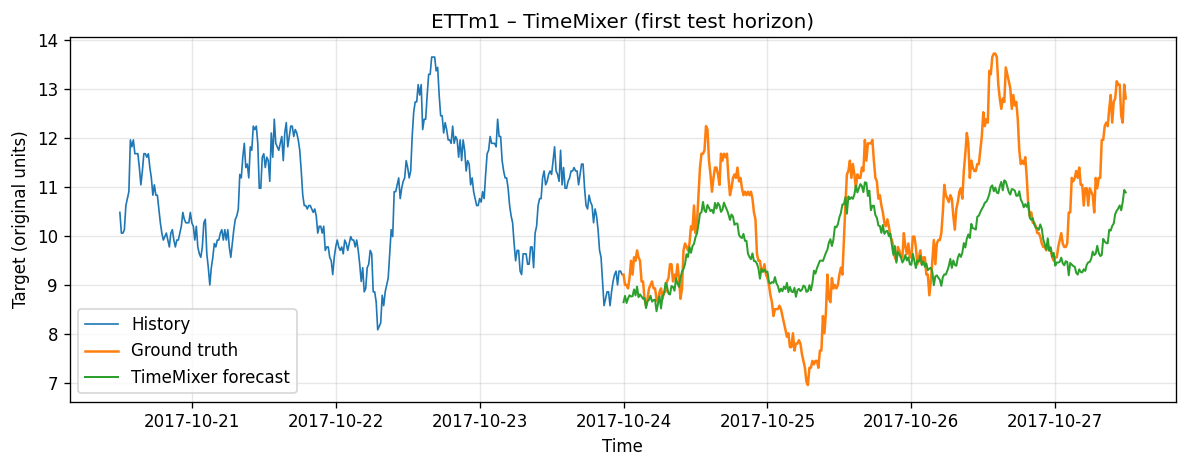

[ETTm1] TimeMixer – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.015883
MAE (scaled): 0.099386
DTW (scaled): 20.906003
TDI (scaled): 0.029540
Saved plot to: results/h336/ETTm1_iTransformer_h336.png


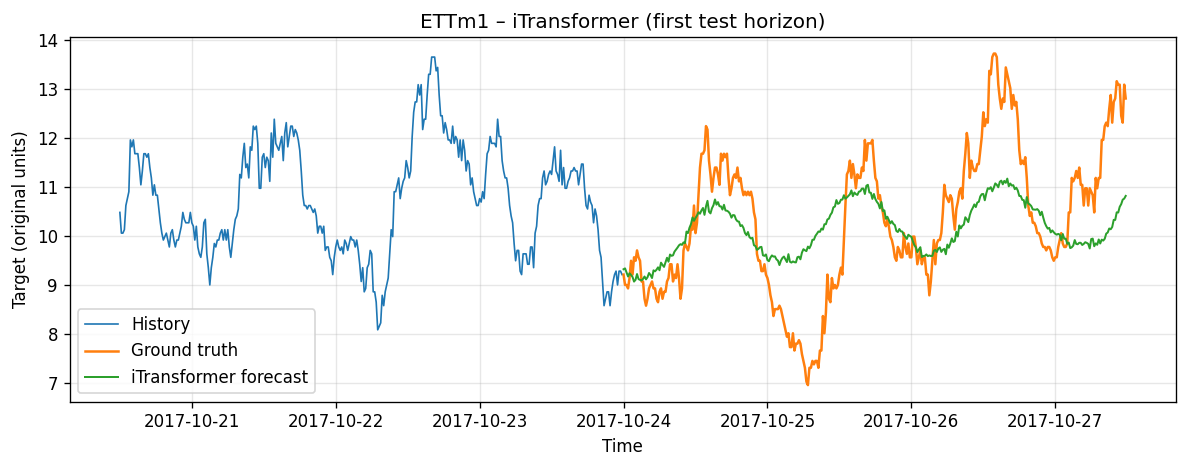

[ETTm1] iTransformer – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.016584
MAE (scaled): 0.101599
DTW (scaled): 24.461583
TDI (scaled): 0.032967

Dataset: ETTm2
[ETTm2] INFO: dataset length 69680 > LTSF total 57600. Using first 57600 points and ignoring extra tail.
Using columns for quantiles -> lower: 0.1, median: predictions, upper: 0.9
Saved plot to: results/h336/ETTm2_Chronos-2_h336.png


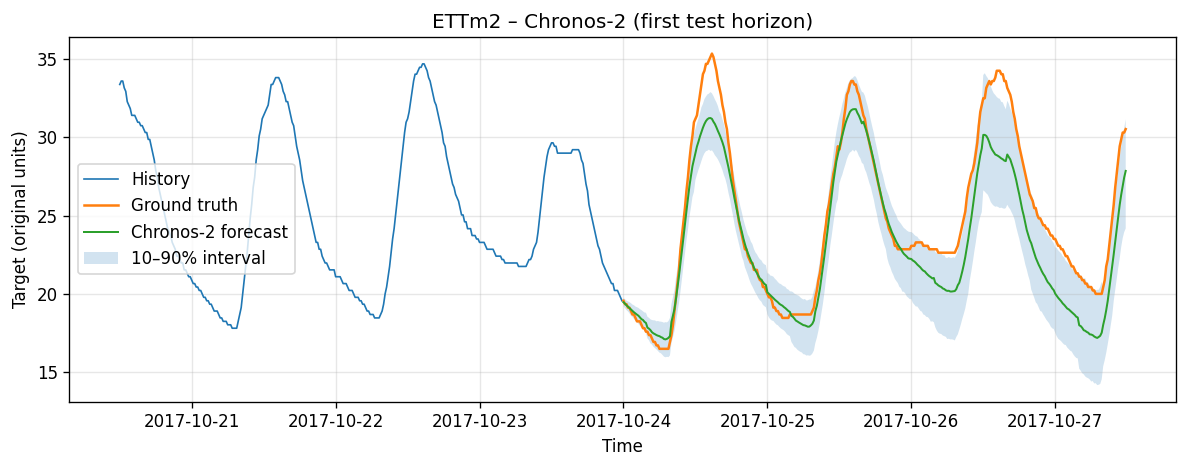

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1


[ETTm2] Chronos-2 – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.037598
MAE (scaled): 0.151727
DTW (scaled): 26.916279
TDI (scaled): 0.020938


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE               │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │  2.2 M │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 2.2 M                                                                                            
Non-trainable params: 3                                                                                            
Total params: 2.2 M                                                                                                
Total estimated model params size (MB): 8                                                                          
Modules in train mode: 90                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train  │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler        │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ decomp        │ SeriesDecomp  │      0 │ train │     0 │
│ 4 │ linear_trend  │ Linear        │  113 K │ train │     0 │
│ 5 │ linear_season │ Linear        │  113 K │ train │     0 │
└───┴───────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 226 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 226 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 8                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃    ┃ Name              ┃ Type                 ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0  │ loss              │ MAE                  │      0 │ train │     0 │
│ 1  │ padder_train      │ ConstantPad1d        │      0 │ train │     0 │
│ 2  │ scaler            │ TemporalNorm         │      0 │ train │     0 │
│ 3  │ pdm_blocks        │ ModuleList           │  1.0 M │ train │     0 │
│ 4  │ preprocess        │ SeriesDecomp         │      0 │ train │     0 │
│ 5  │ enc_embedding     │ DataEmbedding_wo_pos │  2.5 K │ train │     0 │
│ 6  │ normalize_layers  │ ModuleList           │      4 │ train │     0 │
│ 7  │ predict_layers    │ ModuleList           │  170 K │ train │     0 │
│ 8  │ projection_layer  │ Linear               │     33 │ train │     0 │
│ 9  │ out_res_layers    │ ModuleList           │  141 K │ train │     0 │
│ 10 │ regression_layers │ ModuleList           │  170 K │ train │     0 │
└────┴───────────────────┴──────────────────────┴────────┴───────┴───────┘

Trainable params: 1.5 M                                                                                            
Non-trainable params: 2.4 K                                                                                        
Total params: 1.5 M                                                                                                
Total estimated model params size (MB): 6                                                                          
Modules in train mode: 138                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type                   ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ MAE                    │      0 │ train │     0 │
│ 1 │ padder_train  │ ConstantPad1d          │      0 │ train │     0 │
│ 2 │ scaler        │ TemporalNorm           │      0 │ train │     0 │
│ 3 │ enc_embedding │ DataEmbedding_inverted │  172 K │ train │     0 │
│ 4 │ encoder       │ TransEncoder           │  6.3 M │ train │     0 │
│ 5 │ projector     │ Linear                 │  172 K │ train │     0 │
└───┴───────────────┴────────────────────────┴────────┴───────┴───────┘

Trainable params: 6.7 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 6.7 M                                                                                                
Total estimated model params size (MB): 26                                                                         
Modules in train mode: 36                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

Saved plot to: results/h336/ETTm2_PatchTST_h336.png


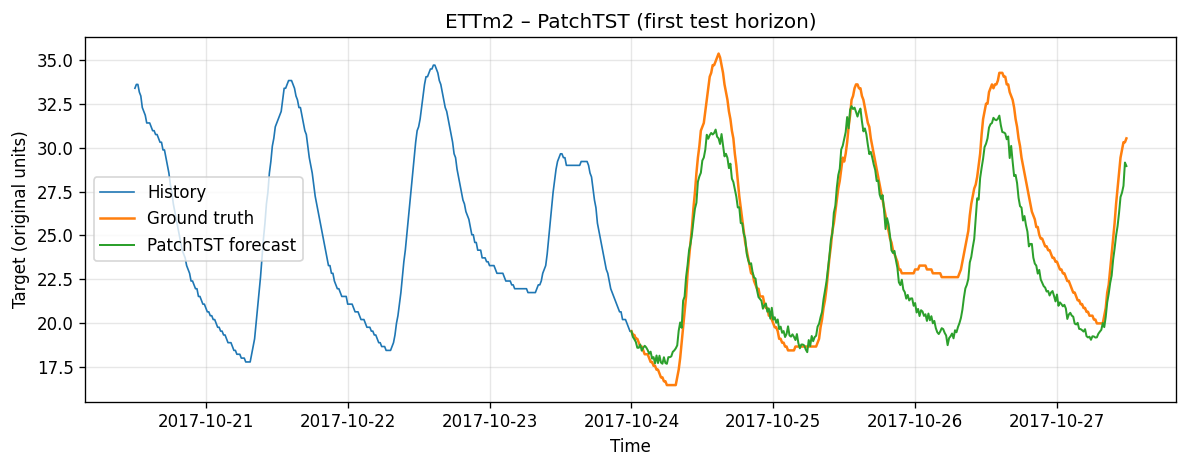

[ETTm2] PatchTST – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.027310
MAE (scaled): 0.133599
DTW (scaled): 24.432360
TDI (scaled): 0.016327
Saved plot to: results/h336/ETTm2_DLinear_h336.png


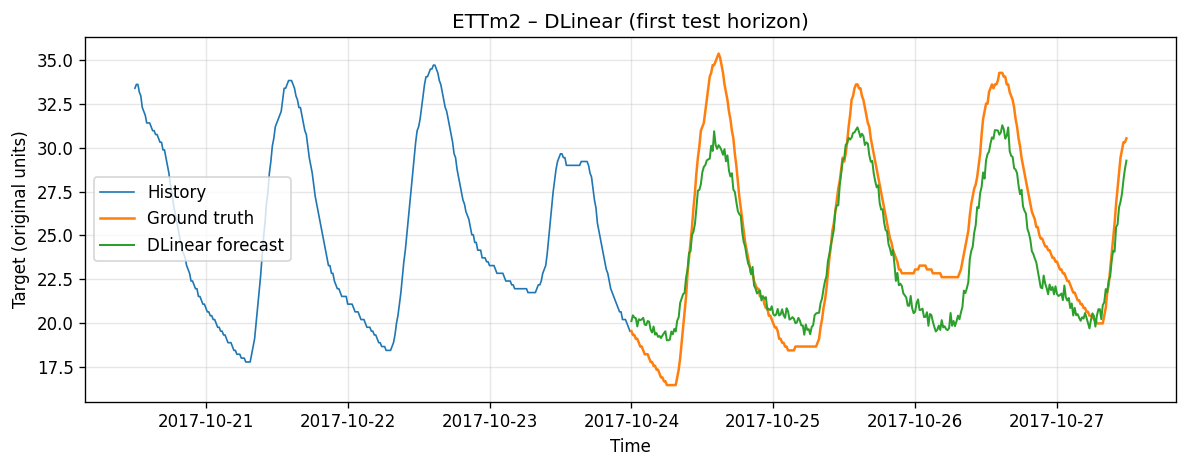

[ETTm2] DLinear – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.033522
MAE (scaled): 0.156170
DTW (scaled): 30.161465
TDI (scaled): 0.022105
Saved plot to: results/h336/ETTm2_TimeMixer_h336.png


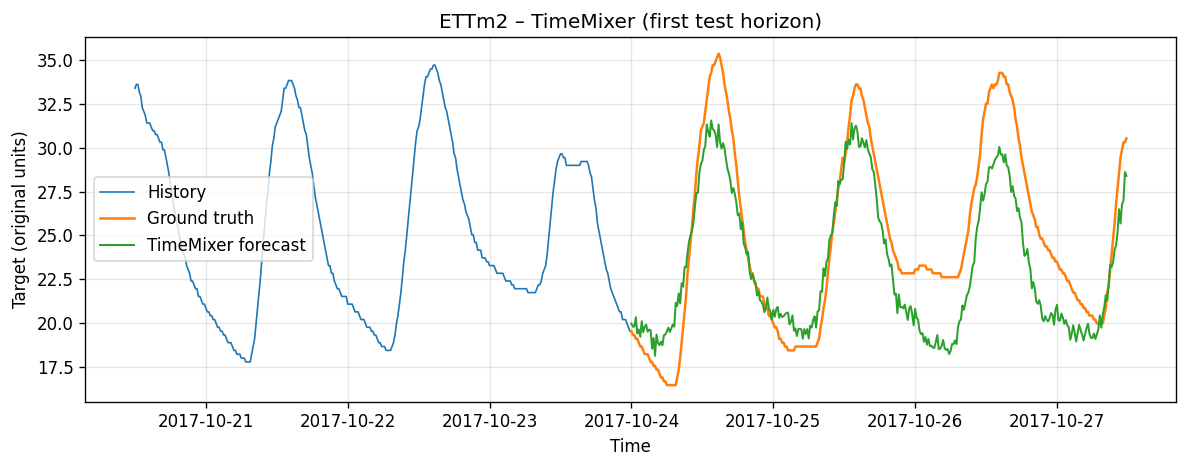

[ETTm2] TimeMixer – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.056013
MAE (scaled): 0.201877
DTW (scaled): 35.590162
TDI (scaled): 0.023114
Saved plot to: results/h336/ETTm2_iTransformer_h336.png


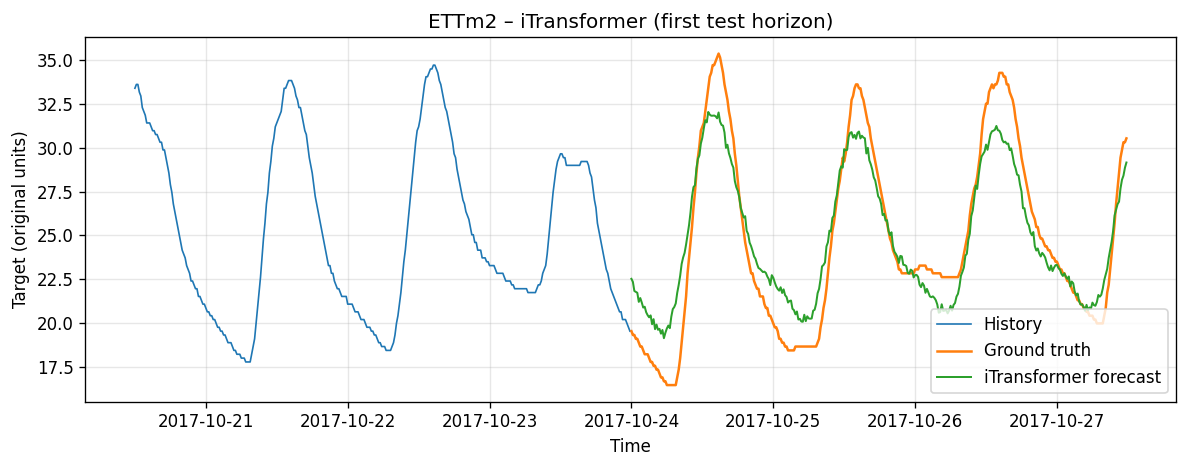

[ETTm2] iTransformer – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.028640
MAE (scaled): 0.140939
DTW (scaled): 27.503801
TDI (scaled): 0.016467

Dataset: Weather
[Weather] WARNING: irregular timestamps; using regular freq '10min'
[Weather] INFO: dataset length 52696 > LTSF total 52603. Using first 52603 points and ignoring extra tail.
Using columns for quantiles -> lower: 0.1, median: predictions, upper: 0.9
Saved plot to: results/h336/Weather_Chronos-2_h336.png


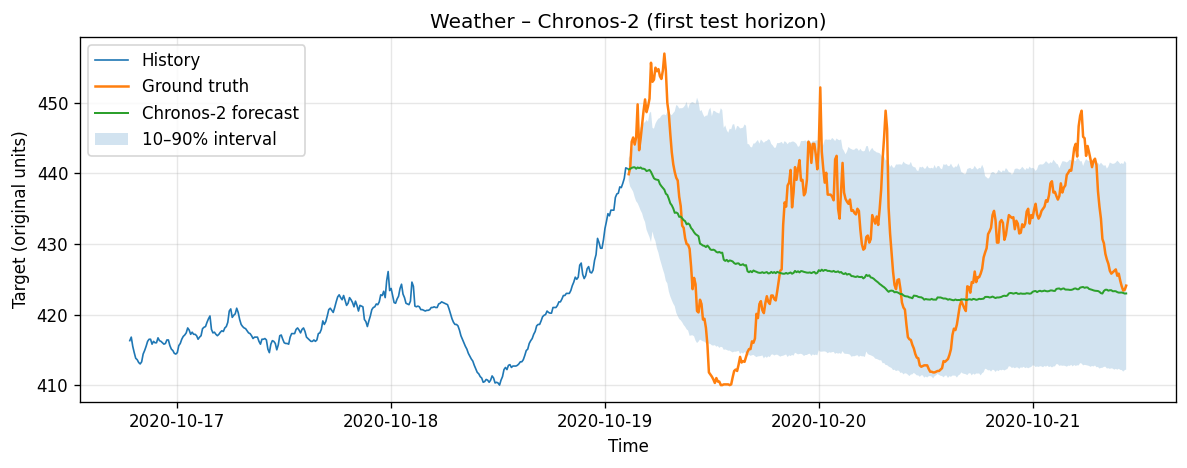

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1


[Weather] Chronos-2 – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.000886
MAE (scaled): 0.025922
DTW (scaled): 8.058503
TDI (scaled): 0.050091


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE               │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │  2.2 M │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 2.2 M                                                                                            
Non-trainable params: 3                                                                                            
Total params: 2.2 M                                                                                                
Total estimated model params size (MB): 8                                                                          
Modules in train mode: 90                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train  │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler        │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ decomp        │ SeriesDecomp  │      0 │ train │     0 │
│ 4 │ linear_trend  │ Linear        │  113 K │ train │     0 │
│ 5 │ linear_season │ Linear        │  113 K │ train │     0 │
└───┴───────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 226 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 226 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 8                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃    ┃ Name              ┃ Type                 ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0  │ loss              │ MAE                  │      0 │ train │     0 │
│ 1  │ padder_train      │ ConstantPad1d        │      0 │ train │     0 │
│ 2  │ scaler            │ TemporalNorm         │      0 │ train │     0 │
│ 3  │ pdm_blocks        │ ModuleList           │  1.0 M │ train │     0 │
│ 4  │ preprocess        │ SeriesDecomp         │      0 │ train │     0 │
│ 5  │ enc_embedding     │ DataEmbedding_wo_pos │  2.5 K │ train │     0 │
│ 6  │ normalize_layers  │ ModuleList           │      4 │ train │     0 │
│ 7  │ predict_layers    │ ModuleList           │  170 K │ train │     0 │
│ 8  │ projection_layer  │ Linear               │     33 │ train │     0 │
│ 9  │ out_res_layers    │ ModuleList           │  141 K │ train │     0 │
│ 10 │ regression_layers │ ModuleList           │  170 K │ train │     0 │
└────┴───────────────────┴──────────────────────┴────────┴───────┴───────┘

Trainable params: 1.5 M                                                                                            
Non-trainable params: 2.4 K                                                                                        
Total params: 1.5 M                                                                                                
Total estimated model params size (MB): 6                                                                          
Modules in train mode: 138                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type                   ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ MAE                    │      0 │ train │     0 │
│ 1 │ padder_train  │ ConstantPad1d          │      0 │ train │     0 │
│ 2 │ scaler        │ TemporalNorm           │      0 │ train │     0 │
│ 3 │ enc_embedding │ DataEmbedding_inverted │  172 K │ train │     0 │
│ 4 │ encoder       │ TransEncoder           │  6.3 M │ train │     0 │
│ 5 │ projector     │ Linear                 │  172 K │ train │     0 │
└───┴───────────────┴────────────────────────┴────────┴───────┴───────┘

Trainable params: 6.7 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 6.7 M                                                                                                
Total estimated model params size (MB): 26                                                                         
Modules in train mode: 36                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

Saved plot to: results/h336/Weather_PatchTST_h336.png


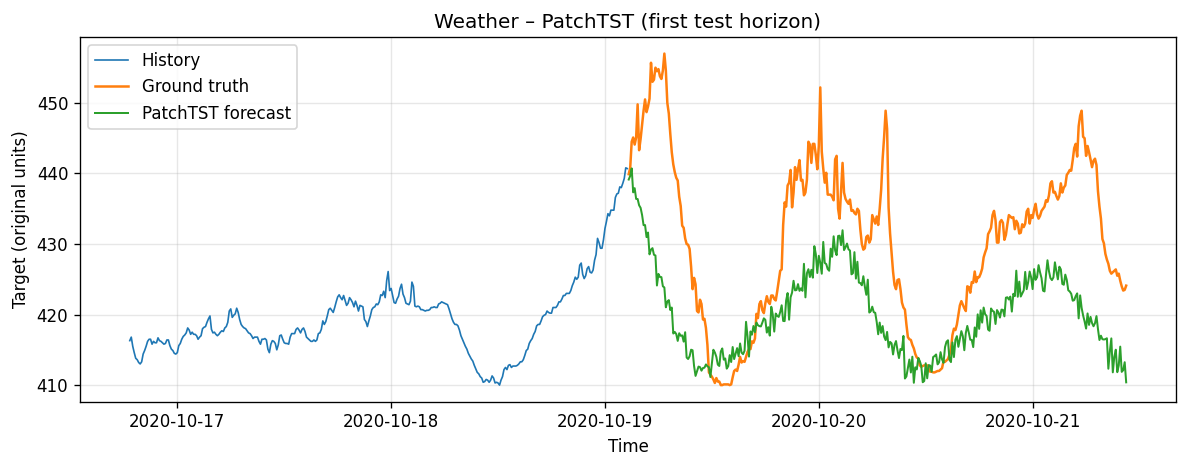

[Weather] PatchTST – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.001157
MAE (scaled): 0.027779
DTW (scaled): 5.147960
TDI (scaled): 0.053913
Saved plot to: results/h336/Weather_DLinear_h336.png


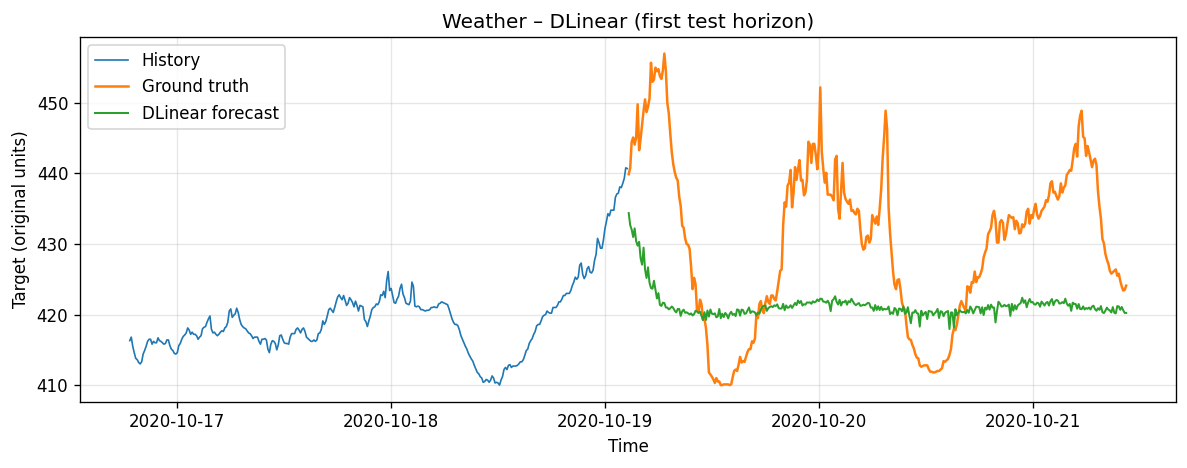

[Weather] DLinear – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.001350
MAE (scaled): 0.030786
DTW (scaled): 8.978343
TDI (scaled): 0.036939
Saved plot to: results/h336/Weather_TimeMixer_h336.png


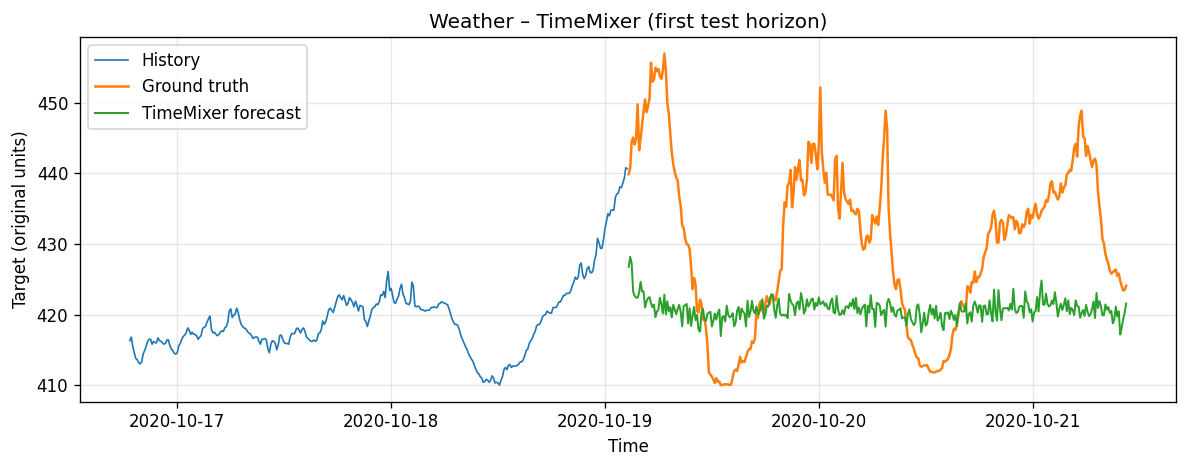

[Weather] TimeMixer – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.001467
MAE (scaled): 0.031947
DTW (scaled): 9.473615
TDI (scaled): 0.039973
Saved plot to: results/h336/Weather_iTransformer_h336.png


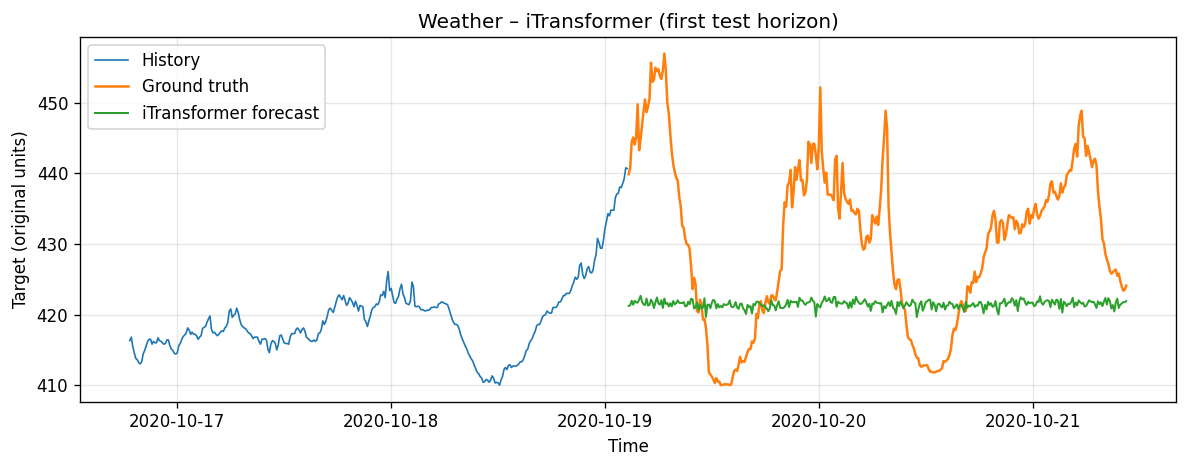

[Weather] iTransformer – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.001436
MAE (scaled): 0.031716
DTW (scaled): 10.386754
TDI (scaled): 0.028198
Saved metrics CSV to: results/h336/metrics_h336.csv


dataset         model  mse_scaled  mae_scaled  dtw_scaled  tdi_scaled  \
0     ETTh1     Chronos-2    0.062555    0.193180   56.808214    0.154187   
1     ETTh1      PatchTST    0.065591    0.214957   37.276441    0.156861   
2     ETTh1       DLinear    0.050888    0.194467   39.174600    0.121449   
3     ETTh1     TimeMixer    0.044372    0.177655   36.967133    0.116545   
4     ETTh1  iTransformer    0.057645    0.198602   44.813601    0.157585   
5     ETTm1     Chronos-2    0.018342    0.107346   28.237847    0.039199   
6     ETTm1      PatchTST    0.022430    0.121927   25.870987    0.036312   
7     ETTm1       DLinear    0.014737    0.096397   18.869918    0.036422   
8     ETTm1     TimeMixer    0.015883    0.099386   20.906003    0.029540   
9     ETTm1  iTransformer    0.016584    0.101599   24.461583    0.032967   
10    ETTm2     Chronos-2    0.037598    0.151727   26.916279    0.020938   
11    ETTm2      PatchTST    0.027310    0.133599   24.432360    0.016327   
12    ETTm2       DLinear    0.033522    0.156170   30.161465    0.022105   
13    ETTm2     TimeMixer    0.056013    0.201877   35.590162    0.023114   
14    ETTm2  iTransformer    0.028640    0.140939   27.503801    0.016467   
15  Weather     Chronos-2    0.000886    0.025922    8.058503    0.050091   
16  Weather      PatchTST    0.001157    0.027779    5.147960    0.053913   
17  Weather       DLinear    0.001350    0.030786    8.978343    0.036939   
18  Weather     TimeMixer    0.001467    0.031947    9.473615    0.039973   
19  Weather  iTransformer    0.001436    0.031716   10.386754    0.028198   

                 protocol  
0   single_horizon_scaled  
1   single_horizon_scaled  
2   single_horizon_scaled  
3   single_horizon_scaled  
4   single_horizon_scaled  
5   single_horizon_scaled  
6   single_horizon_scaled  
7   single_horizon_scaled  
8   single_horizon_scaled  
9   single_horizon_scaled  
10  single_horizon_scaled  
11  single_horizon_scaled  
12  single_horizon_scaled  
13  single_horizon_scaled  
14  single_horizon_scaled  
15  single_horizon_scaled  
16  single_horizon_scaled  
17  single_horizon_scaled  
18  single_horizon_scaled  
19  single_horizon_scaled

In [ ]:
PREDICTION_LENGTH = 336
all_results = []

RESULTS_SUBDIR = os.path.join(BASE_RESULTS_DIR, f"h{PREDICTION_LENGTH}")
os.makedirs(RESULTS_SUBDIR, exist_ok=True)
print("Saving results to:", RESULTS_SUBDIR)

for ds_name, path in DATASETS.items():
    print("\n" + "=" * 80)
    print(f"Dataset: {ds_name}")
    dataset = prepare_dataset(ds_name, path)

    # Chronos-2
    chr_pred_scaled, chr_lower_scaled, chr_upper_scaled = chronos_predict_scaled(
        dataset, pipeline
    )
    res = plot_and_metrics(
        dataset,
        "Chronos-2",
        chr_pred_scaled,
        lower_scaled=chr_lower_scaled,
        upper_scaled=chr_upper_scaled,
        results_dir=RESULTS_SUBDIR,
    )
    all_results.append(res)

    # NeuralForecast models
    nf_preds = nf_predict_scaled(dataset)
    for model_name, pred_scaled in nf_preds.items():
        res = plot_and_metrics(
            dataset,
            model_name,
            pred_scaled,
            results_dir=RESULTS_SUBDIR,
        )
        all_results.append(res)

metrics_df = pd.DataFrame(all_results)

csv_path = os.path.join(RESULTS_SUBDIR, f"metrics_h{PREDICTION_LENGTH}.csv")
metrics_df.to_csv(csv_path, index=False)
print("Saved metrics CSV to:", csv_path)

metrics_df

Saving results to: results/h720

Dataset: ETTh1
[ETTh1] INFO: dataset length 17420 > LTSF total 14400. Using first 14400 points and ignoring extra tail.
Using columns for quantiles -> lower: 0.1, median: predictions, upper: 0.9
Saved plot to: results/h720/ETTh1_Chronos-2_h720.png


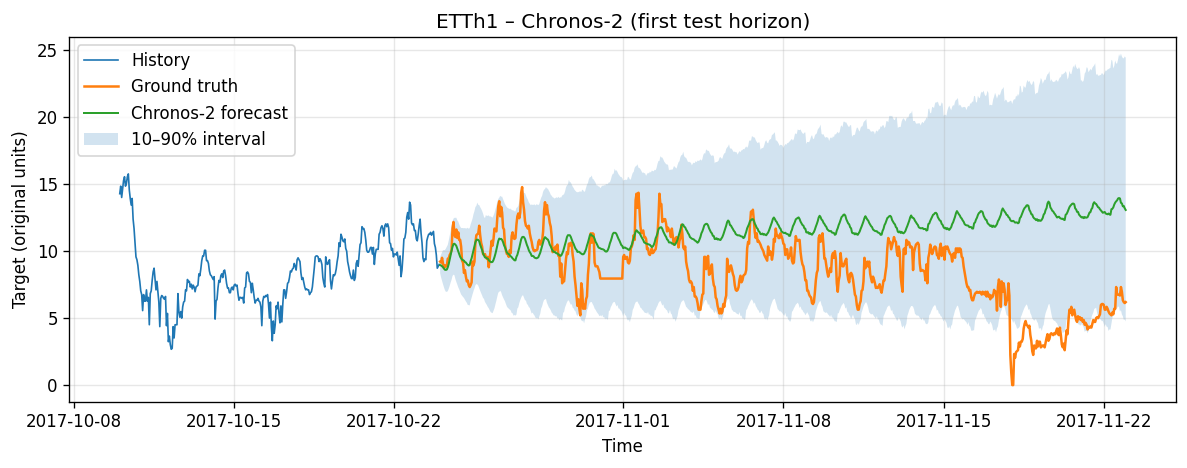

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1


[ETTh1] Chronos-2 – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.233048
MAE (scaled): 0.373450
DTW (scaled): 258.413790
TDI (scaled): 0.043094


INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE               │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │  4.3 M │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 4.3 M                                                                                            
Non-trainable params: 3                                                                                            
Total params: 4.3 M                                                                                                
Total estimated model params size (MB): 17                                                                         
Modules in train mode: 90                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train  │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler        │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ decomp        │ SeriesDecomp  │      0 │ train │     0 │
│ 4 │ linear_trend  │ Linear        │  242 K │ train │     0 │
│ 5 │ linear_season │ Linear        │  242 K │ train │     0 │
└───┴───────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 485 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 485 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 8                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃    ┃ Name              ┃ Type                 ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0  │ loss              │ MAE                  │      0 │ train │     0 │
│ 1  │ padder_train      │ ConstantPad1d        │      0 │ train │     0 │
│ 2  │ scaler            │ TemporalNorm         │      0 │ train │     0 │
│ 3  │ pdm_blocks        │ ModuleList           │  1.0 M │ train │     0 │
│ 4  │ preprocess        │ SeriesDecomp         │      0 │ train │     0 │
│ 5  │ enc_embedding     │ DataEmbedding_wo_pos │  2.5 K │ train │     0 │
│ 6  │ normalize_layers  │ ModuleList           │      4 │ train │     0 │
│ 7  │ predict_layers    │ ModuleList           │  364 K │ train │     0 │
│ 8  │ projection_layer  │ Linear               │     33 │ train │     0 │
│ 9  │ out_res_layers    │ ModuleList           │  141 K │ train │     0 │
│ 10 │ regression_layers │ ModuleList           │  364 K │ train │     0 │
└────┴───────────────────┴──────────────────────┴────────┴───────┴───────┘

Trainable params: 1.9 M                                                                                            
Non-trainable params: 2.4 K                                                                                        
Total params: 1.9 M                                                                                                
Total estimated model params size (MB): 7                                                                          
Modules in train mode: 138                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type                   ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ MAE                    │      0 │ train │     0 │
│ 1 │ padder_train  │ ConstantPad1d          │      0 │ train │     0 │
│ 2 │ scaler        │ TemporalNorm           │      0 │ train │     0 │
│ 3 │ enc_embedding │ DataEmbedding_inverted │  172 K │ train │     0 │
│ 4 │ encoder       │ TransEncoder           │  6.3 M │ train │     0 │
│ 5 │ projector     │ Linear                 │  369 K │ train │     0 │
└───┴───────────────┴────────────────────────┴────────┴───────┴───────┘

Trainable params: 6.8 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 6.8 M                                                                                                
Total estimated model params size (MB): 27                                                                         
Modules in train mode: 36                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

Saved plot to: results/h720/ETTh1_PatchTST_h720.png


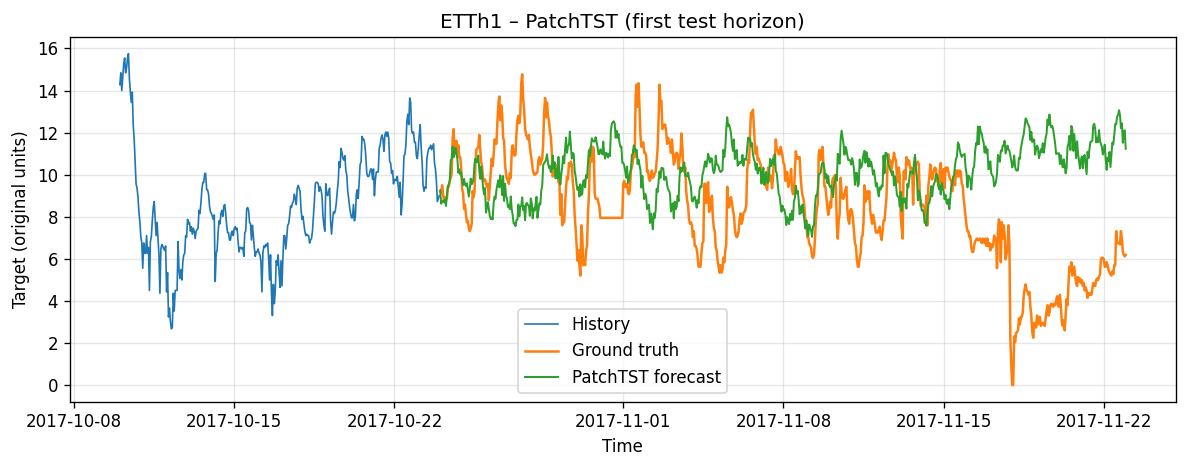

[ETTh1] PatchTST – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.161191
MAE (scaled): 0.310953
DTW (scaled): 160.922919
TDI (scaled): 0.052194
Saved plot to: results/h720/ETTh1_DLinear_h720.png


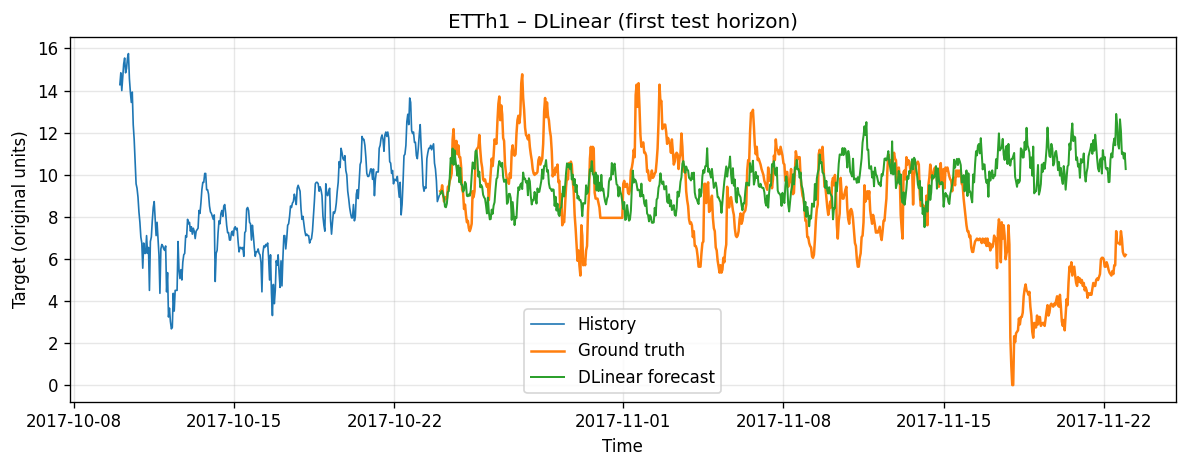

[ETTh1] DLinear – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.128637
MAE (scaled): 0.274225
DTW (scaled): 159.448930
TDI (scaled): 0.079924
Saved plot to: results/h720/ETTh1_TimeMixer_h720.png


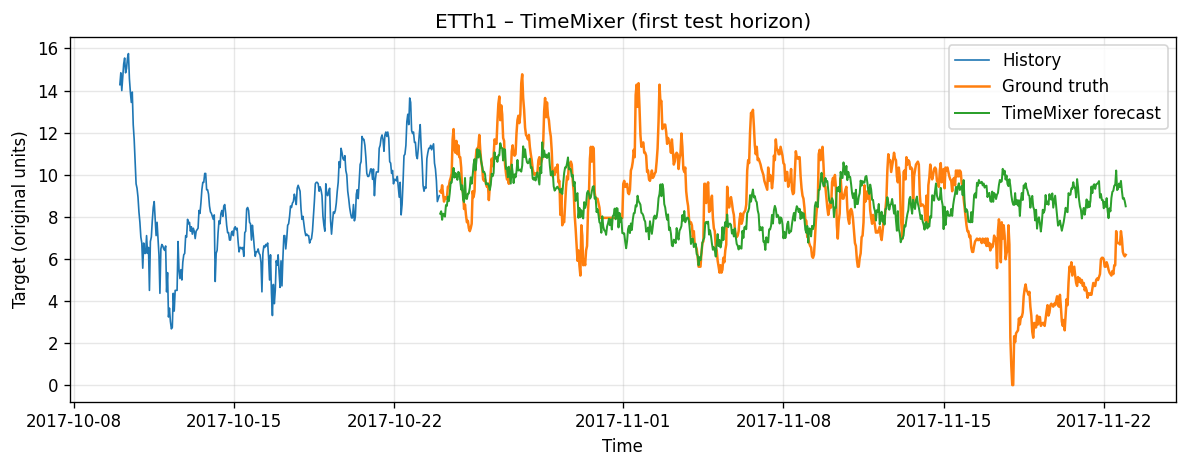

[ETTh1] TimeMixer – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.080270
MAE (scaled): 0.225549
DTW (scaled): 112.135198
TDI (scaled): 0.069329
Saved plot to: results/h720/ETTh1_iTransformer_h720.png


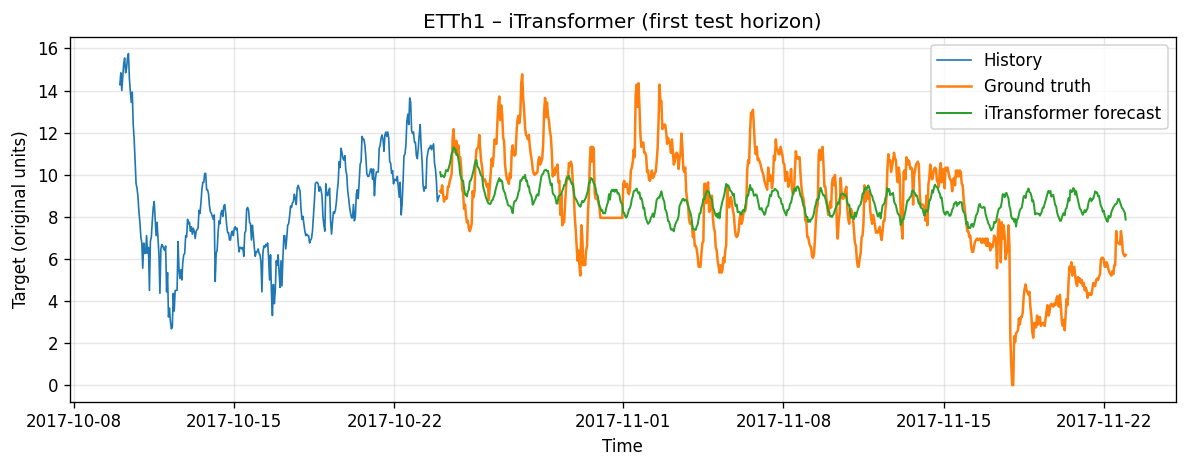

[ETTh1] iTransformer – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.070345
MAE (scaled): 0.209359
DTW (scaled): 124.062459
TDI (scaled): 0.064119

Dataset: ETTm1
[ETTm1] INFO: dataset length 69680 > LTSF total 57600. Using first 57600 points and ignoring extra tail.
Using columns for quantiles -> lower: 0.1, median: predictions, upper: 0.9
Saved plot to: results/h720/ETTm1_Chronos-2_h720.png


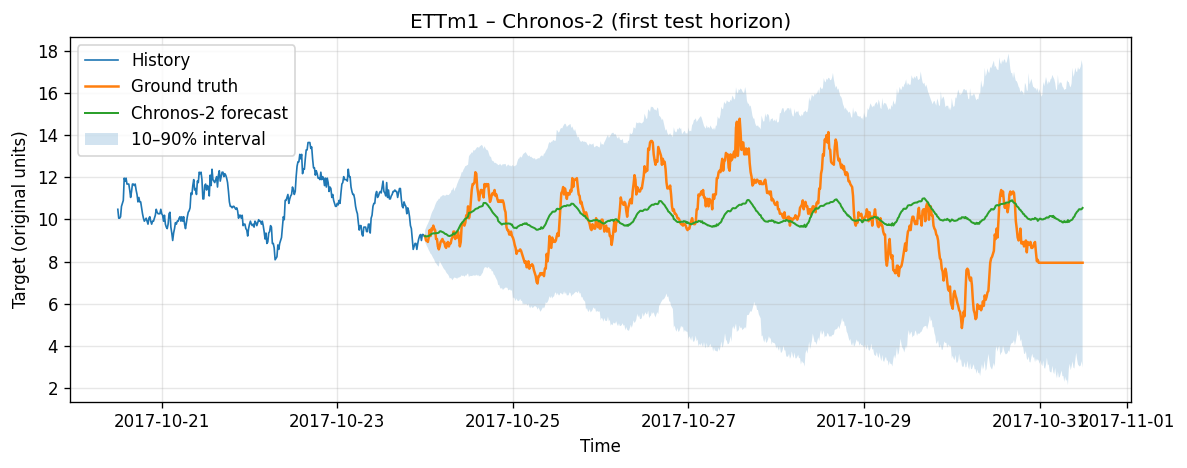

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1


[ETTm1] Chronos-2 – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.034564
MAE (scaled): 0.145718
DTW (scaled): 88.605853
TDI (scaled): 0.078966


INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE               │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │  4.3 M │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 4.3 M                                                                                            
Non-trainable params: 3                                                                                            
Total params: 4.3 M                                                                                                
Total estimated model params size (MB): 17                                                                         
Modules in train mode: 90                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train  │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler        │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ decomp        │ SeriesDecomp  │      0 │ train │     0 │
│ 4 │ linear_trend  │ Linear        │  242 K │ train │     0 │
│ 5 │ linear_season │ Linear        │  242 K │ train │     0 │
└───┴───────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 485 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 485 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 8                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃    ┃ Name              ┃ Type                 ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0  │ loss              │ MAE                  │      0 │ train │     0 │
│ 1  │ padder_train      │ ConstantPad1d        │      0 │ train │     0 │
│ 2  │ scaler            │ TemporalNorm         │      0 │ train │     0 │
│ 3  │ pdm_blocks        │ ModuleList           │  1.0 M │ train │     0 │
│ 4  │ preprocess        │ SeriesDecomp         │      0 │ train │     0 │
│ 5  │ enc_embedding     │ DataEmbedding_wo_pos │  2.5 K │ train │     0 │
│ 6  │ normalize_layers  │ ModuleList           │      4 │ train │     0 │
│ 7  │ predict_layers    │ ModuleList           │  364 K │ train │     0 │
│ 8  │ projection_layer  │ Linear               │     33 │ train │     0 │
│ 9  │ out_res_layers    │ ModuleList           │  141 K │ train │     0 │
│ 10 │ regression_layers │ ModuleList           │  364 K │ train │     0 │
└────┴───────────────────┴──────────────────────┴────────┴───────┴───────┘

Trainable params: 1.9 M                                                                                            
Non-trainable params: 2.4 K                                                                                        
Total params: 1.9 M                                                                                                
Total estimated model params size (MB): 7                                                                          
Modules in train mode: 138                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type                   ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ MAE                    │      0 │ train │     0 │
│ 1 │ padder_train  │ ConstantPad1d          │      0 │ train │     0 │
│ 2 │ scaler        │ TemporalNorm           │      0 │ train │     0 │
│ 3 │ enc_embedding │ DataEmbedding_inverted │  172 K │ train │     0 │
│ 4 │ encoder       │ TransEncoder           │  6.3 M │ train │     0 │
│ 5 │ projector     │ Linear                 │  369 K │ train │     0 │
└───┴───────────────┴────────────────────────┴────────┴───────┴───────┘

Trainable params: 6.8 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 6.8 M                                                                                                
Total estimated model params size (MB): 27                                                                         
Modules in train mode: 36                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

Saved plot to: results/h720/ETTm1_PatchTST_h720.png


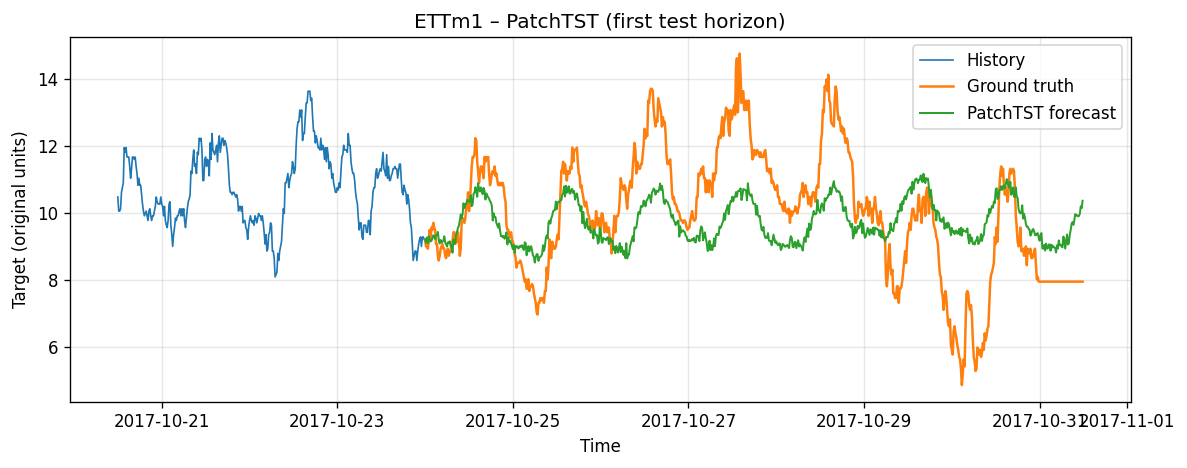

[ETTm1] PatchTST – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.032349
MAE (scaled): 0.147699
DTW (scaled): 81.973092
TDI (scaled): 0.229172
Saved plot to: results/h720/ETTm1_DLinear_h720.png


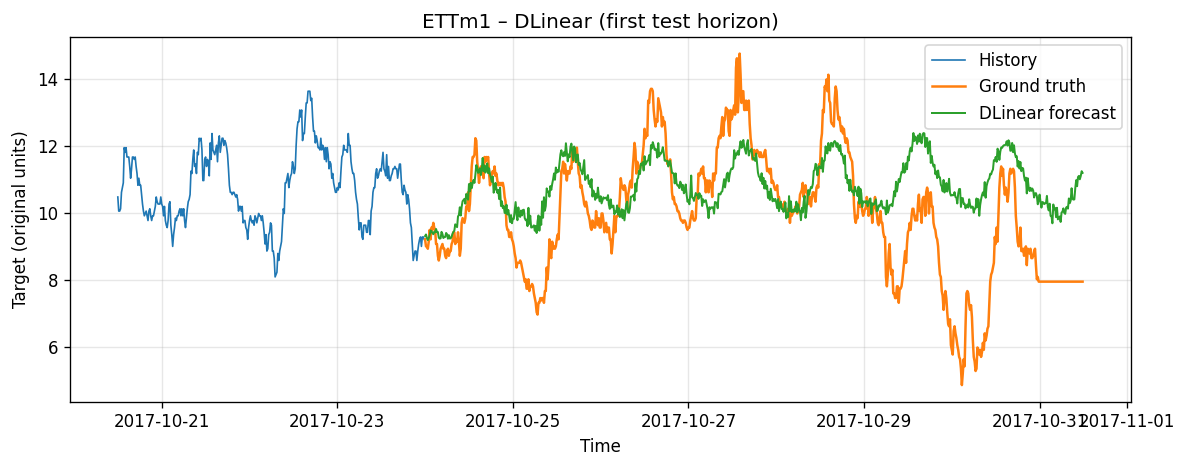

[ETTm1] DLinear – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.037989
MAE (scaled): 0.148952
DTW (scaled): 74.047796
TDI (scaled): 0.133602
Saved plot to: results/h720/ETTm1_TimeMixer_h720.png


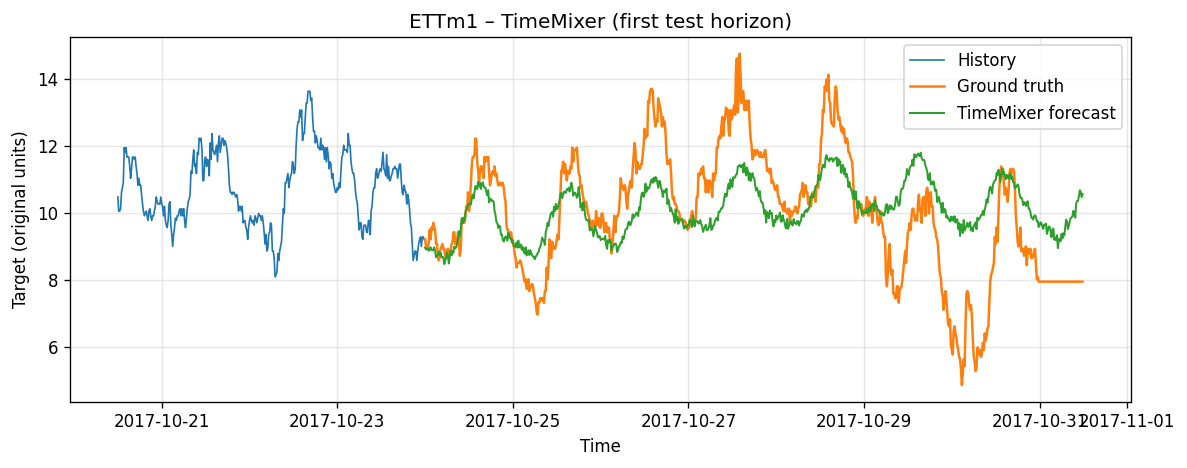

[ETTm1] TimeMixer – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.030012
MAE (scaled): 0.136537
DTW (scaled): 67.904156
TDI (scaled): 0.148311
Saved plot to: results/h720/ETTm1_iTransformer_h720.png


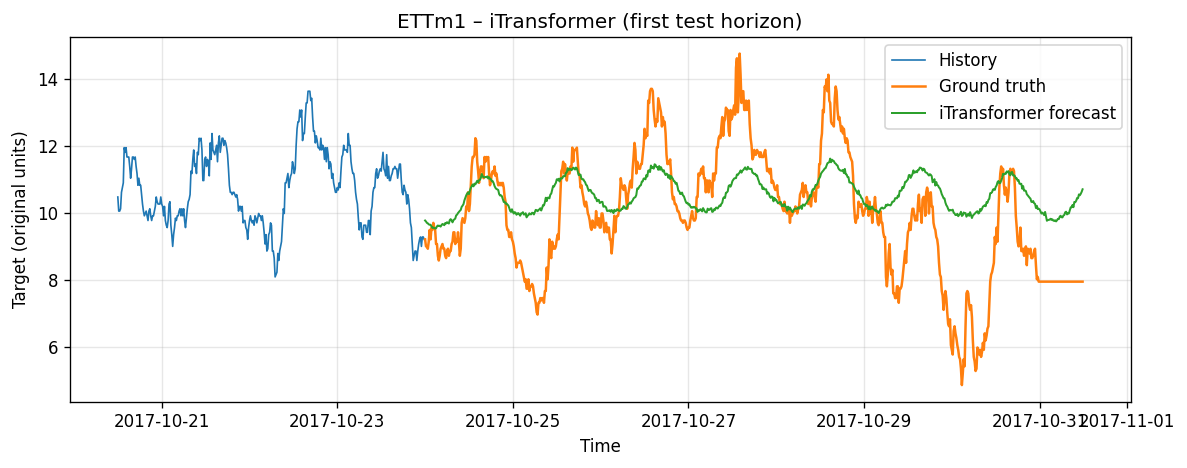

[ETTm1] iTransformer – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.033268
MAE (scaled): 0.141280
DTW (scaled): 89.446843
TDI (scaled): 0.068463

Dataset: ETTm2
[ETTm2] INFO: dataset length 69680 > LTSF total 57600. Using first 57600 points and ignoring extra tail.
Using columns for quantiles -> lower: 0.1, median: predictions, upper: 0.9
Saved plot to: results/h720/ETTm2_Chronos-2_h720.png


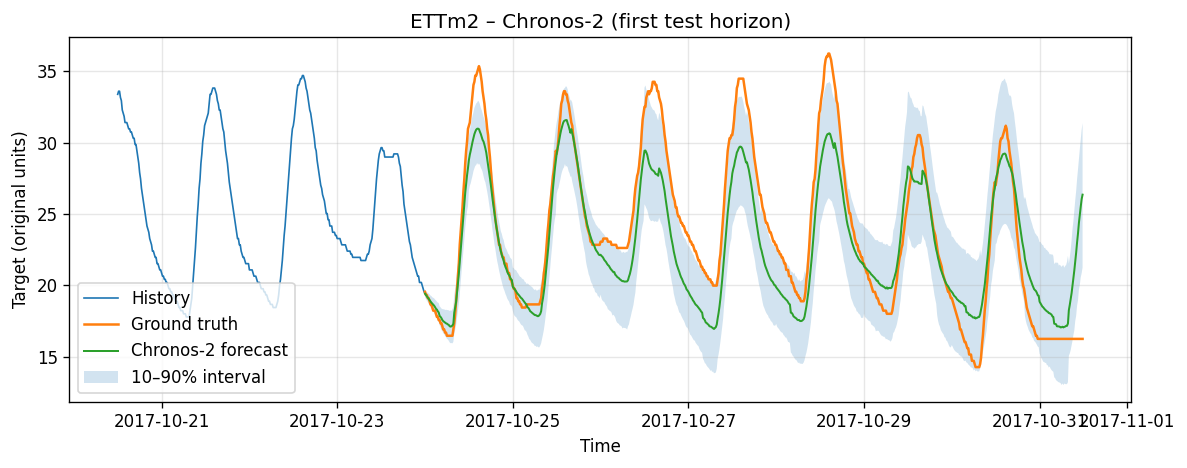

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1


[ETTm2] Chronos-2 – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.053254
MAE (scaled): 0.183383
DTW (scaled): 69.943502
TDI (scaled): 0.010988


INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE               │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │  4.3 M │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 4.3 M                                                                                            
Non-trainable params: 3                                                                                            
Total params: 4.3 M                                                                                                
Total estimated model params size (MB): 17                                                                         
Modules in train mode: 90                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train  │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler        │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ decomp        │ SeriesDecomp  │      0 │ train │     0 │
│ 4 │ linear_trend  │ Linear        │  242 K │ train │     0 │
│ 5 │ linear_season │ Linear        │  242 K │ train │     0 │
└───┴───────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 485 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 485 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 8                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃    ┃ Name              ┃ Type                 ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0  │ loss              │ MAE                  │      0 │ train │     0 │
│ 1  │ padder_train      │ ConstantPad1d        │      0 │ train │     0 │
│ 2  │ scaler            │ TemporalNorm         │      0 │ train │     0 │
│ 3  │ pdm_blocks        │ ModuleList           │  1.0 M │ train │     0 │
│ 4  │ preprocess        │ SeriesDecomp         │      0 │ train │     0 │
│ 5  │ enc_embedding     │ DataEmbedding_wo_pos │  2.5 K │ train │     0 │
│ 6  │ normalize_layers  │ ModuleList           │      4 │ train │     0 │
│ 7  │ predict_layers    │ ModuleList           │  364 K │ train │     0 │
│ 8  │ projection_layer  │ Linear               │     33 │ train │     0 │
│ 9  │ out_res_layers    │ ModuleList           │  141 K │ train │     0 │
│ 10 │ regression_layers │ ModuleList           │  364 K │ train │     0 │
└────┴───────────────────┴──────────────────────┴────────┴───────┴───────┘

Trainable params: 1.9 M                                                                                            
Non-trainable params: 2.4 K                                                                                        
Total params: 1.9 M                                                                                                
Total estimated model params size (MB): 7                                                                          
Modules in train mode: 138                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type                   ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ MAE                    │      0 │ train │     0 │
│ 1 │ padder_train  │ ConstantPad1d          │      0 │ train │     0 │
│ 2 │ scaler        │ TemporalNorm           │      0 │ train │     0 │
│ 3 │ enc_embedding │ DataEmbedding_inverted │  172 K │ train │     0 │
│ 4 │ encoder       │ TransEncoder           │  6.3 M │ train │     0 │
│ 5 │ projector     │ Linear                 │  369 K │ train │     0 │
└───┴───────────────┴────────────────────────┴────────┴───────┴───────┘

Trainable params: 6.8 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 6.8 M                                                                                                
Total estimated model params size (MB): 27                                                                         
Modules in train mode: 36                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

Saved plot to: results/h720/ETTm2_PatchTST_h720.png


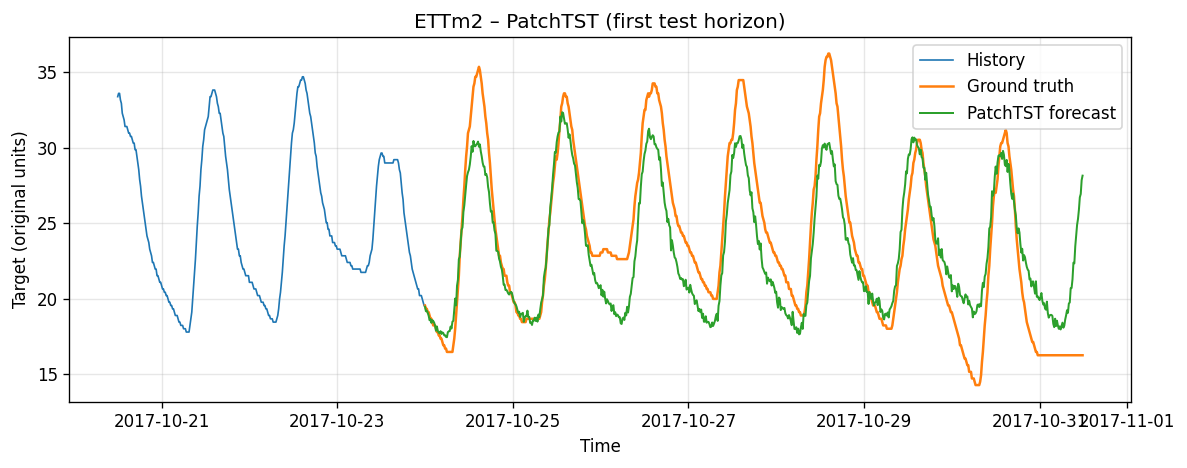

[ETTm2] PatchTST – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.059929
MAE (scaled): 0.196902
DTW (scaled): 73.525348
TDI (scaled): 0.010884
Saved plot to: results/h720/ETTm2_DLinear_h720.png


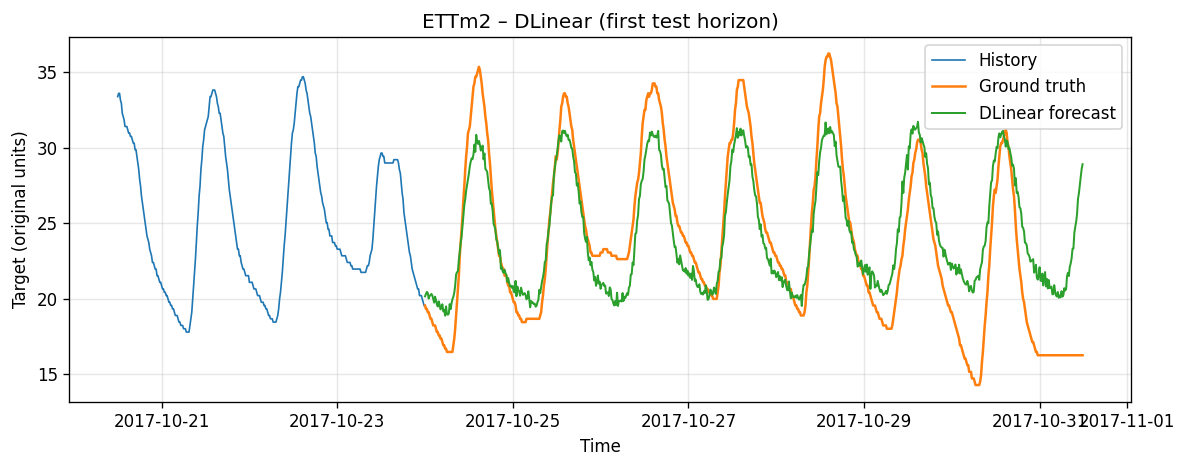

[ETTm2] DLinear – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.068838
MAE (scaled): 0.208283
DTW (scaled): 89.891402
TDI (scaled): 0.011386
Saved plot to: results/h720/ETTm2_TimeMixer_h720.png


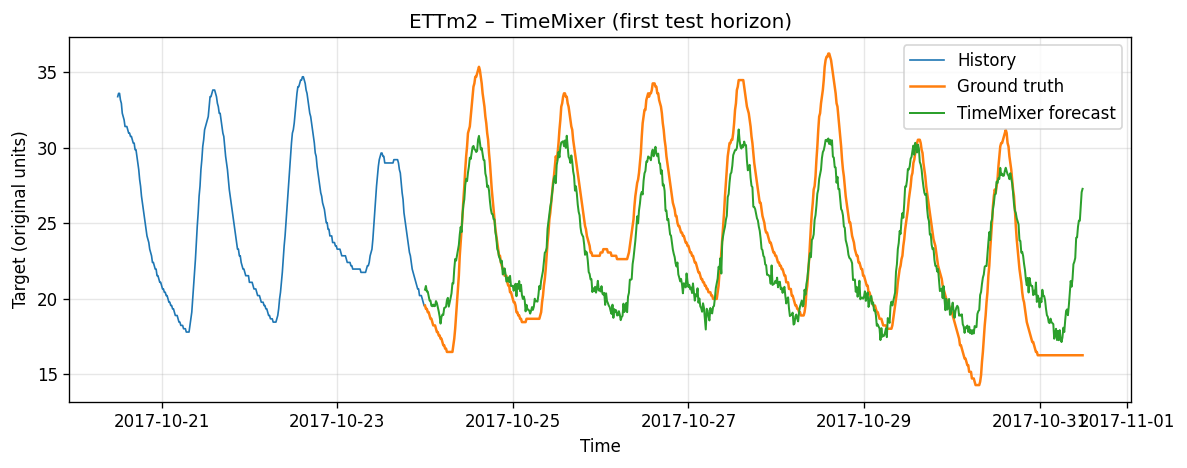

[ETTm2] TimeMixer – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.057314
MAE (scaled): 0.198792
DTW (scaled): 73.565287
TDI (scaled): 0.009883
Saved plot to: results/h720/ETTm2_iTransformer_h720.png


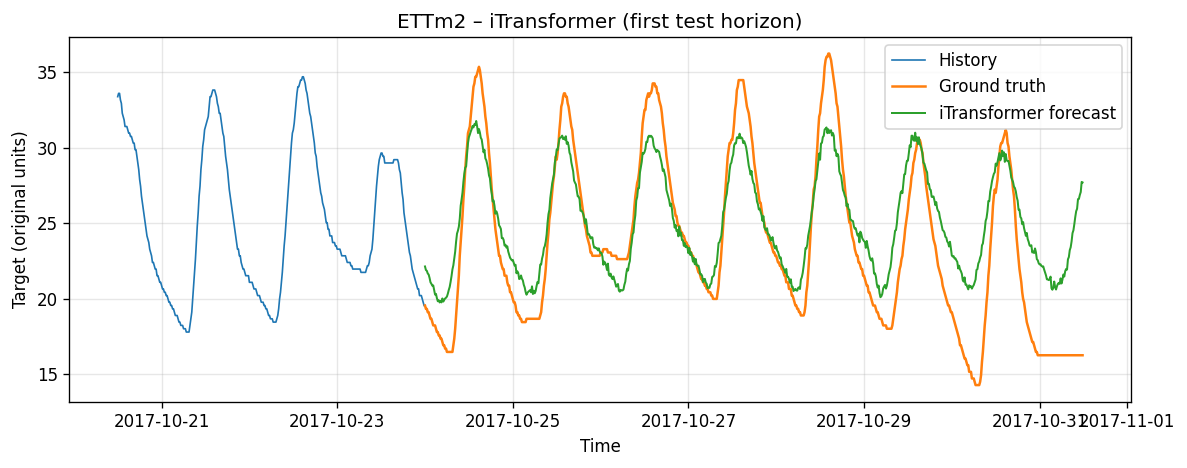

[ETTm2] iTransformer – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.079763
MAE (scaled): 0.221257
DTW (scaled): 95.235230
TDI (scaled): 0.009617

Dataset: Weather
[Weather] WARNING: irregular timestamps; using regular freq '10min'
[Weather] INFO: dataset length 52696 > LTSF total 52603. Using first 52603 points and ignoring extra tail.
Using columns for quantiles -> lower: 0.1, median: predictions, upper: 0.9
Saved plot to: results/h720/Weather_Chronos-2_h720.png


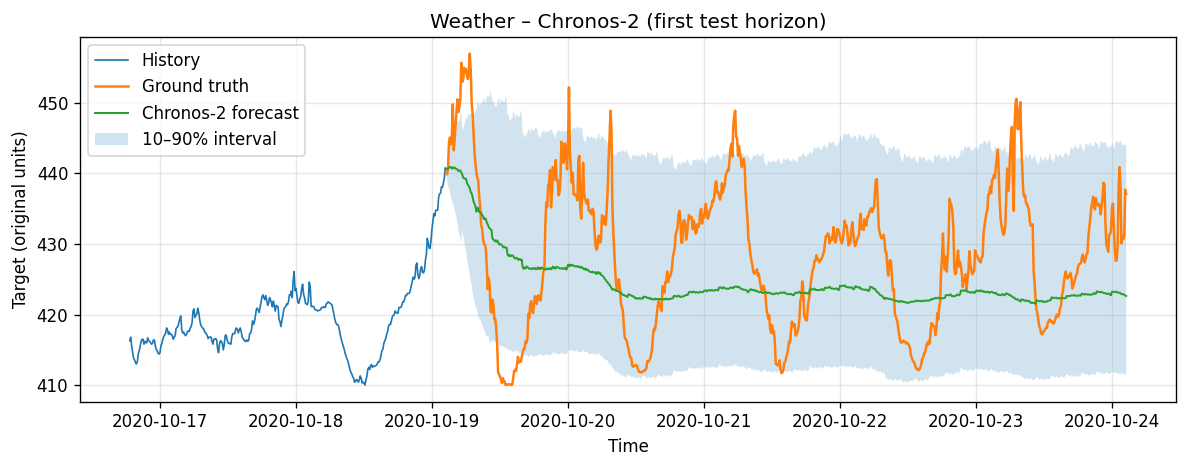

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1


[Weather] Chronos-2 – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.000711
MAE (scaled): 0.022547
DTW (scaled): 15.139253
TDI (scaled): 0.137977


INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE               │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │  4.3 M │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 4.3 M                                                                                            
Non-trainable params: 3                                                                                            
Total params: 4.3 M                                                                                                
Total estimated model params size (MB): 17                                                                         
Modules in train mode: 90                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train  │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler        │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ decomp        │ SeriesDecomp  │      0 │ train │     0 │
│ 4 │ linear_trend  │ Linear        │  242 K │ train │     0 │
│ 5 │ linear_season │ Linear        │  242 K │ train │     0 │
└───┴───────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 485 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 485 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 8                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃    ┃ Name              ┃ Type                 ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0  │ loss              │ MAE                  │      0 │ train │     0 │
│ 1  │ padder_train      │ ConstantPad1d        │      0 │ train │     0 │
│ 2  │ scaler            │ TemporalNorm         │      0 │ train │     0 │
│ 3  │ pdm_blocks        │ ModuleList           │  1.0 M │ train │     0 │
│ 4  │ preprocess        │ SeriesDecomp         │      0 │ train │     0 │
│ 5  │ enc_embedding     │ DataEmbedding_wo_pos │  2.5 K │ train │     0 │
│ 6  │ normalize_layers  │ ModuleList           │      4 │ train │     0 │
│ 7  │ predict_layers    │ ModuleList           │  364 K │ train │     0 │
│ 8  │ projection_layer  │ Linear               │     33 │ train │     0 │
│ 9  │ out_res_layers    │ ModuleList           │  141 K │ train │     0 │
│ 10 │ regression_layers │ ModuleList           │  364 K │ train │     0 │
└────┴───────────────────┴──────────────────────┴────────┴───────┴───────┘

Trainable params: 1.9 M                                                                                            
Non-trainable params: 2.4 K                                                                                        
Total params: 1.9 M                                                                                                
Total estimated model params size (MB): 7                                                                          
Modules in train mode: 138                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type                   ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ MAE                    │      0 │ train │     0 │
│ 1 │ padder_train  │ ConstantPad1d          │      0 │ train │     0 │
│ 2 │ scaler        │ TemporalNorm           │      0 │ train │     0 │
│ 3 │ enc_embedding │ DataEmbedding_inverted │  172 K │ train │     0 │
│ 4 │ encoder       │ TransEncoder           │  6.3 M │ train │     0 │
│ 5 │ projector     │ Linear                 │  369 K │ train │     0 │
└───┴───────────────┴────────────────────────┴────────┴───────┴───────┘

Trainable params: 6.8 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 6.8 M                                                                                                
Total estimated model params size (MB): 27                                                                         
Modules in train mode: 36                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

Saved plot to: results/h720/Weather_PatchTST_h720.png


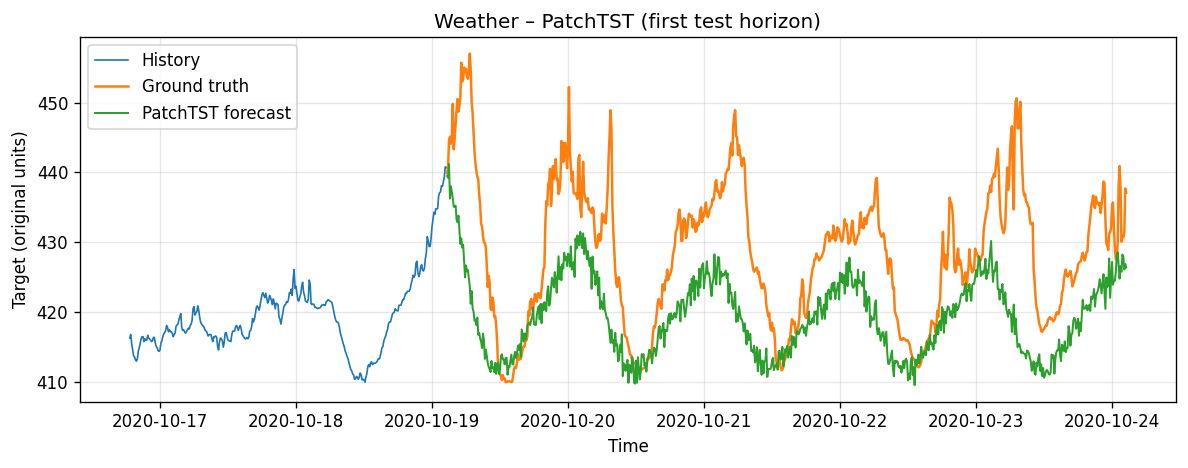

[Weather] PatchTST – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.000929
MAE (scaled): 0.024368
DTW (scaled): 8.269468
TDI (scaled): 0.027441
Saved plot to: results/h720/Weather_DLinear_h720.png


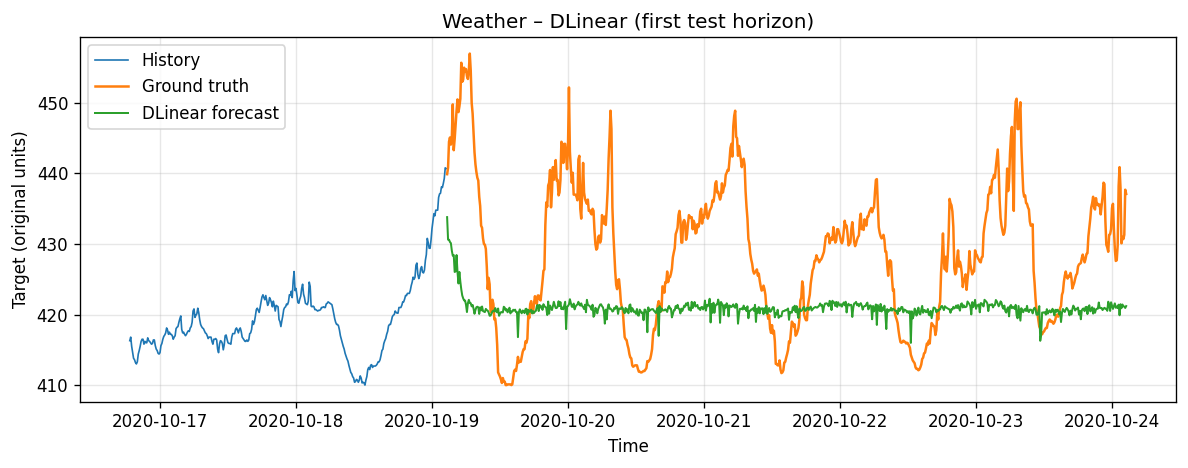

[Weather] DLinear – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.001036
MAE (scaled): 0.026371
DTW (scaled): 16.905816
TDI (scaled): 0.021137
Saved plot to: results/h720/Weather_TimeMixer_h720.png


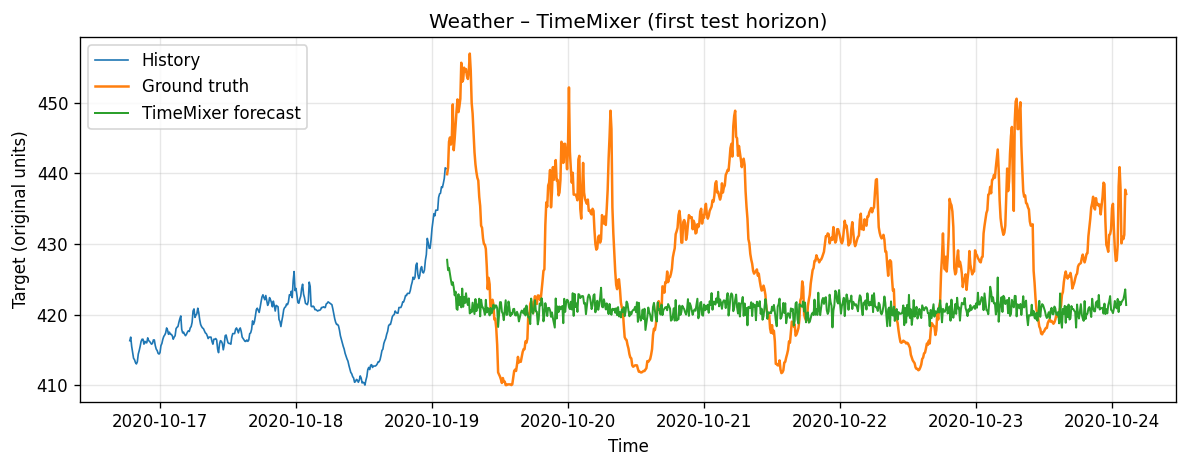

[Weather] TimeMixer – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.001042
MAE (scaled): 0.026411
DTW (scaled): 16.530138
TDI (scaled): 0.024983
Saved plot to: results/h720/Weather_iTransformer_h720.png


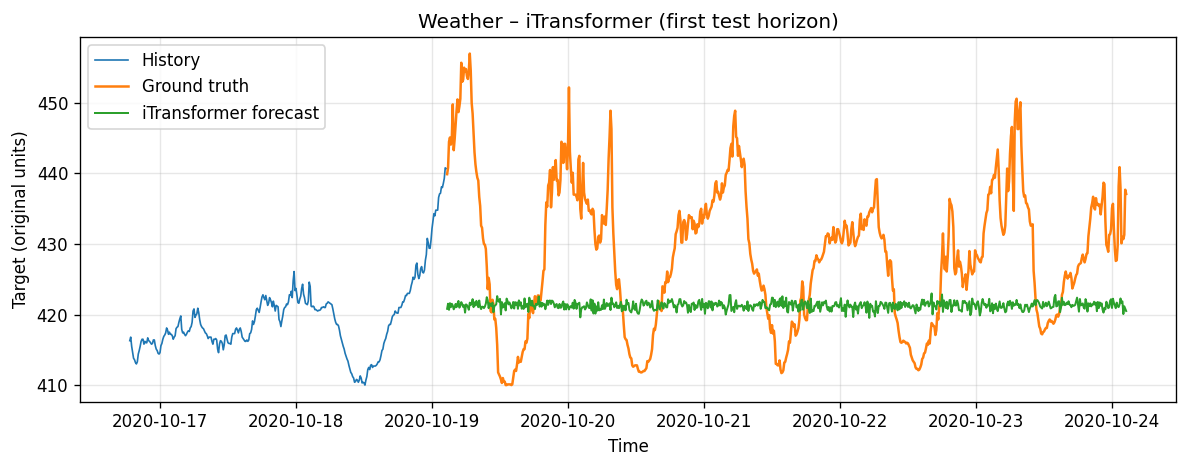

[Weather] iTransformer – single horizon (ALL METRICS SCALED)
MSE (scaled): 0.001066
MAE (scaled): 0.026822
DTW (scaled): 18.867582
TDI (scaled): 0.026897
Saved metrics CSV to: results/h720/metrics_h720.csv


dataset         model  mse_scaled  mae_scaled  dtw_scaled  tdi_scaled  \
0     ETTh1     Chronos-2    0.233048    0.373450  258.413790    0.043094   
1     ETTh1      PatchTST    0.161191    0.310953  160.922919    0.052194   
2     ETTh1       DLinear    0.128637    0.274225  159.448930    0.079924   
3     ETTh1     TimeMixer    0.080270    0.225549  112.135198    0.069329   
4     ETTh1  iTransformer    0.070345    0.209359  124.062459    0.064119   
5     ETTm1     Chronos-2    0.034564    0.145718   88.605853    0.078966   
6     ETTm1      PatchTST    0.032349    0.147699   81.973092    0.229172   
7     ETTm1       DLinear    0.037989    0.148952   74.047796    0.133602   
8     ETTm1     TimeMixer    0.030012    0.136537   67.904156    0.148311   
9     ETTm1  iTransformer    0.033268    0.141280   89.446843    0.068463   
10    ETTm2     Chronos-2    0.053254    0.183383   69.943502    0.010988   
11    ETTm2      PatchTST    0.059929    0.196902   73.525348    0.010884   
12    ETTm2       DLinear    0.068838    0.208283   89.891402    0.011386   
13    ETTm2     TimeMixer    0.057314    0.198792   73.565287    0.009883   
14    ETTm2  iTransformer    0.079763    0.221257   95.235230    0.009617   
15  Weather     Chronos-2    0.000711    0.022547   15.139253    0.137977   
16  Weather      PatchTST    0.000929    0.024368    8.269468    0.027441   
17  Weather       DLinear    0.001036    0.026371   16.905816    0.021137   
18  Weather     TimeMixer    0.001042    0.026411   16.530138    0.024983   
19  Weather  iTransformer    0.001066    0.026822   18.867582    0.026897   

                 protocol  
0   single_horizon_scaled  
1   single_horizon_scaled  
2   single_horizon_scaled  
3   single_horizon_scaled  
4   single_horizon_scaled  
5   single_horizon_scaled  
6   single_horizon_scaled  
7   single_horizon_scaled  
8   single_horizon_scaled  
9   single_horizon_scaled  
10  single_horizon_scaled  
11  single_horizon_scaled  
12  single_horizon_scaled  
13  single_horizon_scaled  
14  single_horizon_scaled  
15  single_horizon_scaled  
16  single_horizon_scaled  
17  single_horizon_scaled  
18  single_horizon_scaled  
19  single_horizon_scaled

In [ ]:
PREDICTION_LENGTH = 720
all_results = []

RESULTS_SUBDIR = os.path.join(BASE_RESULTS_DIR, f"h{PREDICTION_LENGTH}")
os.makedirs(RESULTS_SUBDIR, exist_ok=True)
print("Saving results to:", RESULTS_SUBDIR)

for ds_name, path in DATASETS.items():
    print("\n" + "=" * 80)
    print(f"Dataset: {ds_name}")
    dataset = prepare_dataset(ds_name, path)

    # Chronos-2
    chr_pred_scaled, chr_lower_scaled, chr_upper_scaled = chronos_predict_scaled(
        dataset, pipeline
    )
    res = plot_and_metrics(
        dataset,
        "Chronos-2",
        chr_pred_scaled,
        lower_scaled=chr_lower_scaled,
        upper_scaled=chr_upper_scaled,
        results_dir=RESULTS_SUBDIR,
    )
    all_results.append(res)

    # NeuralForecast models
    nf_preds = nf_predict_scaled(dataset)
    for model_name, pred_scaled in nf_preds.items():
        res = plot_and_metrics(
            dataset,
            model_name,
            pred_scaled,
            results_dir=RESULTS_SUBDIR,
        )
        all_results.append(res)

metrics_df = pd.DataFrame(all_results)

csv_path = os.path.join(RESULTS_SUBDIR, f"metrics_h{PREDICTION_LENGTH}.csv")
metrics_df.to_csv(csv_path, index=False)
print("Saved metrics CSV to:", csv_path)

metrics_df

In [ ]:
import shutil
import os

directory_to_zip = 'results'
output_zip_name = 'results.zip'

shutil.make_archive(output_zip_name.split('.')[0], 'zip', directory_to_zip)

'/content/results.zip'